In [ ]:
# Tercera Iteracion
# En esta parte se abordara el problema desde un enfoque de aprendizaje semi-supervisado. Dado que
# el etiquetado es un proceso manual y relativamente lento, planteamos etiquetar un conjunto de entre-
# namiento mas amplio utilizando un algoritmo de co-training. Los pasos sugeridos son:

In [1]:
# Instalo librerias que a lo mejor necesito
! pip install ipynb --upgrade
! pip install import-ipynb

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from mpl_finance import candlestick2_ohlc
from datetime import datetime 
from dateutil.parser import parse
from datetime import datetime
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import sklearn
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import accuracy_score, roc_auc_score
# sklearn.metrics.SCORERS.keys() # para saber todas la metricas que puedo usar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

In [3]:
# 1. Utilizar un conjunto etiquetado en las partes anteriores y desarrollar un conjunto independiente
# de nuevas caracterısticas. Si se dispone de mas de 5 caracterısticas se podrıan partir en 2 sub-
# conjuntos.

In [4]:
# 1.1 recupero las etiquetas de la iteracion 2
ejemplos = pd.read_csv('ejemplos_doble_suelo_doble_techo.csv')
ejemplos.columns = ['fecha','etiqueta','idfechas']
ejemplos

,fecha,etiqueta,idfechas
0,2008-02-29,1.0,2058.0
1,2007-11-19,0.0,1989.0
2,2018-07-11,0.0,4704.0
3,2007-01-10,1.0,1769.0
4,2017-05-29,1.0,4418.0
...,...,...,...
132,2012-06-04,0.0,3144.0
133,2000-08-28,0.0,167.0
134,2003-02-05,0.0,775.0
135,2013-05-16,0.0,3386.0


In [6]:
#1.1.1 cuantos no dobles suelos/doble techo tengo, doble techo tengo y doble suelos tengo
# y ver si hay algun descartado; que no deberia tener
ejemplos['etiqueta'][ejemplos['etiqueta'] == 0.0].count(), ejemplos['etiqueta'][ejemplos['etiqueta'] == 1.0].count(), ejemplos['etiqueta'][ejemplos['etiqueta'] == 2.0].count(), ejemplos['etiqueta'][ejemplos['etiqueta'] == 3.0].count(),

(123, 9, 5, 0)

In [7]:
# 1.2 Genero de nuevo las caracteriticas de el df de etiquetas de la iteracion 2 porque
# no lo habia salvado

In [8]:
# 1.2.1 Defino la funcion de escalado y la de StandardScaler; por si las necesito
def preprocesamiento_scale(df):
    import pandas as pd
    from sklearn.preprocessing import scale
    df_arr =  scale(df)
    df =  pd.DataFrame(df_arr, index = df.index, columns=df.columns)
    
    return df, df.mean()

In [9]:
#Como alternativa más adecuada podemos utilizar los "Scalers" de sklearn que nos permiten
#guardar la transformación para aplicarlos sobre otros datasets, por ejemplo el de test.
def preprocesamiento_StandardScaler(df):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df_z_array = scaler.fit_transform(df) # saca la distribucion estandat y lo aplicaca a si mismo
    df_z = pd.DataFrame(df_z_array, columns=df.columns)
    return df_z

In [10]:
# 1.2.2 Necerito el df del ibex para poder hacer la generacion de caracterirticas como lo hice en la iteracion 2
# extraer datos del ibex (sin dividendos) desde 2000-01-03 hasta 2019-06-10
with open('../data/benchmark_data.pkl', 'rb') as handle:
    bm = pickle.load(handle)
ibex = bm['ibex']

In [12]:
# 1.2.3 Generar caracterısticas como en el ejercicio 2

columnas = ['Ejemplo_n','Primer_dia','Ultimo_dia','Valor_Etiqueta','condicion_1', 'condicion_2','condicion_3_1',
            'condicion_3_2','condicion_4_1','condicion_5_1', 'condicion_6_1','condicion_7_1']
df_data = ibex
n= ejemplos.shape[0]
df = pd.DataFrame(0, index=np.arange(n), columns = columnas)
df_data['lista'] =range(0,df_data.shape[0])
for i in range(0,ejemplos.shape[0]):

    with open(f'OHLC_pck_Ej_5_2/{i}_OHLC_Ej5_2.pkl', 'rb') as handle:
        bm_aux = pickle.load(handle)

        columnas = ['close','high','low','open','vol','r_v','Valor_Etiqueta','Numero_Ejemplo','Fecha_Inicio_Ejemplo','idfechas']
        bm = pd.DataFrame( index = bm_aux.index, columns = columnas)
        bm.close = bm_aux.close
        bm.high = bm_aux.high
        bm.low= bm_aux.low
        bm.open = bm_aux.open
        bm.vol = bm_aux.vol
        bm.r_v = bm_aux.r_v
        bm.Valor_Etiqueta = bm_aux.Valor_Etiqueta
        bm.Numero_Ejemplo = bm_aux.Numero_Ejemplo
        bm.Fecha_Inicio_Ejemplo = bm_aux.Fecha_Inicio_Ejemplo
        bm.idfechas = bm_aux.idfechas

    a,b = preprocesamiento_scale(bm.iloc[:,0:4])
    bm.close = a.close
    bm.high = a.high
    bm.low = a.low
    bm.open = a.open


#  CONDICION_1
    MAX = bm.index[bm.high == bm.high.max()][0]
    MIN = bm.index[bm.low == bm.low.min()][0]
    # condicion_1 =abs(int(bm[bm.index == MAX].lista.values) - int(bm[bm.index == MIN].lista.values))
    # condicion_1 =abs(int(bm[bm.index == MAX].lista.values) - int(bm[bm.index == MIN].lista.values))
    condicion_1 =abs(int(df_data[df_data.index == MAX].lista.values) - int(df_data[df_data.index == MIN].lista.values))
    
#  CONDICION_2
    posicion_max = bm.index[bm.high == bm.high.max()][0] - bm.index[0]
    posicion_min = bm.index[bm.low == bm.low.min()] - bm.index[0]
    try:
        if (posicion_max > posicion_min):  
            condicion_2 = 1 #primero es en minimo
        else: 
            condicion_2 = 0 #primero es en maximo o el mismo dia

    except ValueError:
        condicion_2 = 1
    
   
#  CONDICION_3
    umbral = bm.open[0] * 0.05
    umbral_superior = bm.open[0] + umbral
    umbral_inferior =  bm.open[0] - umbral
    numero_de_veces_superar_maximo = 0
    numero_de_veces_superar_minimo = 0
    for i_2 in range(0,bm.shape[0]):
        if bm.high[i_2] > umbral_superior:
            numero_de_veces_superar_maximo = numero_de_veces_superar_maximo + 1
        if bm.low[i_2] < umbral_inferior:
            numero_de_veces_superar_minimo  = numero_de_veces_superar_minimo + 1
    condicion_3_1 = numero_de_veces_superar_maximo
    condicion_3_2 = numero_de_veces_superar_minimo
    
# • CONDICION_4_1: calculo la variacion de volumne del nivel mas bajo con respecto a la media de volumen del periodo
    condicion_4_1 = (bm.loc[bm.low == bm.low.min()]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))

# • CONDICION_5_1: calculo la variacion de volumne del segundo nivel mas bajo con respecto a la media de volumen del periodo
    lows = list(bm.low)
    lows.sort(reverse=False)
    condicion_5 = 0
    condicion_5_1 = (bm.loc[bm.low == lows[1]]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))    

# • CONDICION_6_1: calculo la variacion de volumne del nivel mas alto con respecto a la media de volumen del periodo
    condicion_6_1 = (bm.loc[bm.high == bm.high.min()]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))

# • CONDICION_7_1: calculo la variacion de volumne del segundo nivel mas bajo con respecto a la media de volumen del periodo
    high = list(bm.high)
    high.sort(reverse=True)
    condicion_7_1 = (bm.loc[bm.high == high[1]]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol'])) 


    columnas = ['Ejemplo_n','Valor_Etiqueta','condicion_1', 'condicion_2','condicion_3_1',
               'condicion_3_2','condicion_4','condicion_4_1','condicion_5','condicion_5_1']
    df.loc[i,'condicion_1'] = condicion_1
    df.loc[i,'condicion_2'] = condicion_2
    df.loc[i,'condicion_3_1'] = condicion_3_1
    df.loc[i,'condicion_3_2'] = condicion_3_2
    # df.loc[i,'condicion_4'] = condicion_4
    df.loc[i,'condicion_4_1'] = condicion_4_1
    # df.loc[i,'condicion_5'] = condicion_5
    df.loc[i,'condicion_5_1'] = condicion_5_1
    df.loc[i,'condicion_6_1'] = condicion_6_1
    df.loc[i,'condicion_7_1'] = condicion_7_1  
    df.loc[i,'Valor_Etiqueta'] = bm['Valor_Etiqueta'][0]
    df.loc[i,'Ejemplo_n'] = i    
    df.loc[i,'Primer_dia'] = bm.index[0].strftime('%Y-%m-%d')
    df.loc[i,'Ultimo_dia'] = bm.index[-1].strftime('%Y-%m-%d')
    ve= bm['Valor_Etiqueta'][0]
    pri_dia = bm.index[0].strftime('%Y-%m-%d')
    ult_dia = bm.index[-1].strftime('%Y-%m-%d')
df

,Ejemplo_n,Primer_dia,Ultimo_dia,Valor_Etiqueta,condicion_1,condicion_2,condicion_3_1,condicion_3_2,condicion_4_1,condicion_5_1,condicion_6_1,condicion_7_1
0,0,2008-02-29,2008-05-13,1,48,1,50,2,0.113237,0.515546,0.113237,0.170791
1,1,2007-11-19,2008-02-01,0,13,0,4,42,-0.384593,-0.324094,-0.361012,0.020604
2,2,2018-07-11,2018-09-18,0,42,0,0,50,0.166753,0.041905,0.166753,0.461907
3,3,2007-01-10,2007-03-20,1,33,1,49,2,0.167837,0.100248,0.167837,0.420954
4,4,2017-05-29,2017-08-04,1,19,0,27,20,-0.003635,-0.068074,-0.227245,-0.300109
...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,2012-06-04,2012-08-10,0,13,1,50,46,0.494160,-0.209857,-0.209857,-0.254008
133,133,2000-08-28,2000-11-06,0,19,0,20,30,0.291312,-0.117280,0.291312,0.033087
134,134,2003-02-05,2003-04-15,0,38,0,0,47,-0.027338,-0.164278,-0.027338,-0.087487
135,135,2013-05-16,2013-07-24,0,12,0,6,15,-0.261512,-0.207332,-0.261512,-0.014910


In [13]:
# # 1.2.4 guardo para luego subirlo un csv con el df maestro
# asi, si pasa algo con el programa lo puedo recuperar
df.to_csv('df_maestro_Ej_5_3.csv') ##################################################RECUPARLO LUEGO
df_maestro = pd.read_csv('df_maestro_Ej_5_3.csv', header=0)
# etiquetas y condiciones las pongo mas descriptivas
df_maestro.Valor_Etiqueta = df_maestro.Valor_Etiqueta.astype(int)
df_maestro.condicion_1 = df_maestro.condicion_1.astype(int)
df_maestro.condicion_2 = df_maestro.condicion_2.astype(int)
df_maestro.condicion_3_1 = df_maestro.condicion_3_1.astype(int)
df_maestro.condicion_3_2 = df_maestro.condicion_3_2.astype(int)
df_maestro.condicion_4_1 = df_maestro.condicion_4_1.astype(float)
df_maestro.condicion_5_1 = df_maestro.condicion_5_1.astype(float)
df_maestro.condicion_6_1 = df_maestro.condicion_6_1.astype(float)
df_maestro.condicion_7_1 = df_maestro.condicion_7_1.astype(float)
df_maestro.Valor_Etiqueta = df_maestro.Valor_Etiqueta.replace(0, "no")
df_maestro.Valor_Etiqueta = df_maestro.Valor_Etiqueta.replace(1, "doble_suelo")
df_maestro.Valor_Etiqueta = df_maestro.Valor_Etiqueta.replace(2, "doble_techo")
df_maestro_original_sin_escalado = df_maestro.iloc[:,5:13]
df_maestro

,Unnamed: 0,Ejemplo_n,Primer_dia,Ultimo_dia,Valor_Etiqueta,condicion_1,condicion_2,condicion_3_1,condicion_3_2,condicion_4_1,condicion_5_1,condicion_6_1,condicion_7_1
0,0,0,2008-02-29,2008-05-13,doble_suelo,48,1,50,2,0.113237,0.515546,0.113237,0.170791
1,1,1,2007-11-19,2008-02-01,no,13,0,4,42,-0.384593,-0.324094,-0.361012,0.020604
2,2,2,2018-07-11,2018-09-18,no,42,0,0,50,0.166753,0.041905,0.166753,0.461907
3,3,3,2007-01-10,2007-03-20,doble_suelo,33,1,49,2,0.167837,0.100248,0.167837,0.420954
4,4,4,2017-05-29,2017-08-04,doble_suelo,19,0,27,20,-0.003635,-0.068074,-0.227245,-0.300109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,132,2012-06-04,2012-08-10,no,13,1,50,46,0.494160,-0.209857,-0.209857,-0.254008
133,133,133,2000-08-28,2000-11-06,no,19,0,20,30,0.291312,-0.117280,0.291312,0.033087
134,134,134,2003-02-05,2003-04-15,no,38,0,0,47,-0.027338,-0.164278,-0.027338,-0.087487
135,135,135,2013-05-16,2013-07-24,no,12,0,6,15,-0.261512,-0.207332,-0.261512,-0.014910


In [14]:
# Pequeno chequeo que se ha recuperado bien la informacion del csv
df_maestro.Valor_Etiqueta[df_maestro.Valor_Etiqueta == "doble_techo"].count() # esta bien guradado y extraido

5

In [15]:
# Pequeno chequeo que se ha recuperado bien la informacion del csv
df_maestro.Valor_Etiqueta[df_maestro.Valor_Etiqueta == "doble_suelo"].count() # esta bien guradado y extraido

9

In [16]:
# 1.2.5 desarrollar un conjunto independiente de nuevas caracter´ısticas. Si se dispone 
# de mas de 5 caracterısticas se podr´ıan partir en 2 sub-conjuntos. 
# genero un df df_maestro_grupo_1 con 4 caracteriticas del df_maestro
# genero un df df_maestro_grupo_2 con 4 caracteriticas independientes a df_maestro_grupo_1 del df_maestro

In [17]:
df_maestro_grupo_1 = df_maestro.iloc[:,0:5]
df_maestro_grupo_1['condicion_1'] = df_maestro.condicion_1
df_maestro_grupo_1['condicion_3_1'] = df_maestro.condicion_3_1
df_maestro_grupo_1['condicion_4_1'] = df_maestro.condicion_4_1
df_maestro_grupo_1['condicion_6_1'] = df_maestro.condicion_6_1

df_maestro_grupo_2 = df_maestro.iloc[:,0:5]
df_maestro_grupo_2['condicion_2'] = df_maestro.condicion_2
df_maestro_grupo_2['condicion_3_2'] = df_maestro.condicion_3_2
df_maestro_grupo_2['condicion_5_1'] = df_maestro.condicion_5_1
df_maestro_grupo_2['condicion_7_1'] = df_maestro.condicion_7_1

In [18]:
df_maestro_grupo_1

,Unnamed: 0,Ejemplo_n,Primer_dia,Ultimo_dia,Valor_Etiqueta,condicion_1,condicion_3_1,condicion_4_1,condicion_6_1
0,0,0,2008-02-29,2008-05-13,doble_suelo,48,50,0.113237,0.113237
1,1,1,2007-11-19,2008-02-01,no,13,4,-0.384593,-0.361012
2,2,2,2018-07-11,2018-09-18,no,42,0,0.166753,0.166753
3,3,3,2007-01-10,2007-03-20,doble_suelo,33,49,0.167837,0.167837
4,4,4,2017-05-29,2017-08-04,doble_suelo,19,27,-0.003635,-0.227245
...,...,...,...,...,...,...,...,...,...
132,132,132,2012-06-04,2012-08-10,no,13,50,0.494160,-0.209857
133,133,133,2000-08-28,2000-11-06,no,19,20,0.291312,0.291312
134,134,134,2003-02-05,2003-04-15,no,38,0,-0.027338,-0.027338
135,135,135,2013-05-16,2013-07-24,no,12,6,-0.261512,-0.261512


In [19]:
df_maestro_grupo_2

,Unnamed: 0,Ejemplo_n,Primer_dia,Ultimo_dia,Valor_Etiqueta,condicion_2,condicion_3_2,condicion_5_1,condicion_7_1
0,0,0,2008-02-29,2008-05-13,doble_suelo,1,2,0.515546,0.170791
1,1,1,2007-11-19,2008-02-01,no,0,42,-0.324094,0.020604
2,2,2,2018-07-11,2018-09-18,no,0,50,0.041905,0.461907
3,3,3,2007-01-10,2007-03-20,doble_suelo,1,2,0.100248,0.420954
4,4,4,2017-05-29,2017-08-04,doble_suelo,0,20,-0.068074,-0.300109
...,...,...,...,...,...,...,...,...,...
132,132,132,2012-06-04,2012-08-10,no,1,46,-0.209857,-0.254008
133,133,133,2000-08-28,2000-11-06,no,0,30,-0.117280,0.033087
134,134,134,2003-02-05,2003-04-15,no,0,47,-0.164278,-0.087487
135,135,135,2013-05-16,2013-07-24,no,0,15,-0.207332,-0.014910


In [20]:
# 1.2.6 he de calcular el mejor arbol y el mejor knn, como lo hice ne el ejercicio 2 para luego predecir lOS valores de S'
# para calcular el mejor_arbol uso el df_maestro_grupo_1
# para caulcular el mejor_knn, uso el df_maestro_grupo_2

In [22]:
def matriz_confusion(y_real, y_pred):
    real = pd.Series(y_real, name='Real')
    predicted = pd.Series(y_pred, name="Predicted")
    return pd.crosstab(predicted, real)


y_train: {'doble_suelo': 5, 'doble_techo': 3, 'no': 74}
y_test: {'doble_suelo': 4, 'doble_techo': 2, 'no': 49}
accuracy_score: 0.7636363636363637
Matriz de Confusi´on
Real         doble_suelo  doble_techo  no
Predicted                                
doble_suelo            1            0   6
doble_techo            0            0   2
no                     3            2  41
accuracy
   fit_time  score_time  test_accuracy
0  0.011003    0.002000       0.800000
1  0.002997    0.009025       0.852941
2  0.001978    0.002008       0.735294
3  0.001999    0.002001       0.882353
accuracy_mean
fit_time         0.004494
score_time       0.003759
test_accuracy    0.817647
dtype: float64
class: 0
class: 1
class: 0
class: 1
class: 0
class: 1
class: 0
class: 1
Resultados de KFold(n_splits=4, shuffle=True); absolutos:
   accuracy
0  0.800000
1  0.911765
2  0.941176
3  0.794118
Resultados de KFold(n_splits=4, shuffle=True); medias: 
accuracy    0.861765
dtype: float64
mayor:2
mejor i_acc de las cla

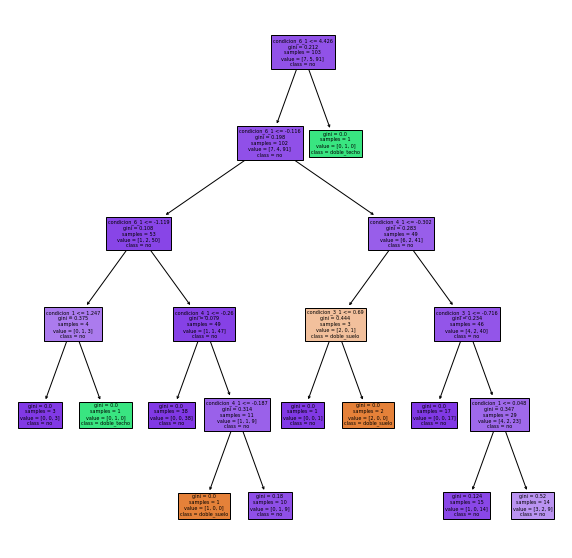

In [28]:
# 3.1. dTree. Primer algoritmo. Lo hago correr en el df_maestro_grupo_1


features = df_maestro_grupo_1.loc[:,df_maestro_grupo_1.columns[5:9]]
target = df_maestro_grupo_1.loc[:,df_maestro_grupo_1.columns[4]]

##############################
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,1,2,3]])

features.condicion_1 = features_2.condicion_1
features.condicion_3_1 = features_2.condicion_3_1

features.condicion_4_1 = features_2.condicion_4_1

features.condicion_6_1 = features_2.condicion_6_1

################


x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.4,
                                                    stratify=target.values)
vals, counts = np.unique(y_train, return_counts=True)
print(f'y_train: {dict(zip(vals, counts))}')
vals, counts = np.unique(y_test, return_counts=True)
print(f'y_test: {dict(zip(vals, counts))}')
dTree = DecisionTreeClassifier(max_depth=5)
_ = dTree.fit(x_train, y_train)

test_predicted = dTree.predict(x_test)
pd.DataFrame({'label': y_test, 
              'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')
print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']
scores = cross_validate(dTree, features, target, scoring=scoring, cv=4) # intenta con cv = 3
print('accuracy')
print(pd.DataFrame(scores))
print('accuracy_mean')
print(pd.DataFrame(scores).mean())


kfold = KFold(n_splits=4, shuffle=True)
acc = []

mejor_arbol = dTree ##############
i= 0 #########
mejor_modelo = 0 ############
mayor = 0 ####
features_arr = features.to_numpy()
for train, test in kfold.split(features_arr):
    
    fold_train_x = features_arr[train]
    fold_train_y = target[train]
    arbol = dTree.fit(fold_train_x, fold_train_y) 

    fold_test_x = features_arr[test]
    fold_test_y = target[test]
    
    i_acc = dTree.score(fold_test_x, fold_test_y)
    
    i_class = np.where(dTree.classes_ == 'doble_suelo')[0][0]
    print('class:', i_class)
    fold_test_pred = dTree.predict_proba(fold_test_x)[:,i_class]
    
    
    i_class = np.where(dTree.classes_ == 'doble_techo')[0][0]
    print('class:', i_class)
    fold_test_pred = dTree.predict_proba(fold_test_x)[:,i_class]
    acc.append(i_acc)
    
    #SALVO EL MODELO CON MAYOR i_acc que usare para seguir con el ejercicio
    if i_acc > mejor_modelo: ##########
        mejor_modelo = i_acc
        import copy
        mejor_arbol = copy.copy(arbol)
        mayor = i #########
    
    i= i+1 #########
    
result = pd.DataFrame({'accuracy':acc})
print('Resultados de KFold(n_splits=4, shuffle=True); absolutos:')
print(result)
print('Resultados de KFold(n_splits=4, shuffle=True); medias: ')
print(result.mean())

dTree_features = features
dTree_target = target
dTree_x_test = x_test
dTree_y_test = y_test


print(f'mayor:{mayor}')
print(f'mejor i_acc de las clases de este modelo es la numero:{mejor_modelo}')
print(mejor_arbol)
fig, ax = plt.subplots(figsize=(10,10)) #########
_ = plot_tree(mejor_arbol, feature_names=features.columns, #########
                        class_names=arbol.classes_, #########
                        filled=True) #########
mayor_dTree_orden = mayor ##########
mayor_dTree_iac = mejor_modelo ###############

In [59]:
# 3.2.  Gausiano. Segundo algoritmo. Lo hago correr en el df_maestro_grupo_2

features = df_maestro_grupo_2.loc[:,df_maestro_grupo_2.columns[5:9]]
target = df_maestro_grupo_2.loc[:,df_maestro_grupo_2.columns[4]]

##############################
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,1,2,3]])
features.condicion_2 = features_2.condicion_2
features.condicion_3_2 = features_2.condicion_3_2
features.condicion_5_1 = features_2.condicion_5_1
features.condicion_7_1 = features_2.condicion_7_1
################

x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.4,
                                                    stratify=target.values)
vals, counts = np.unique(y_train, return_counts=True)
print(f'y_train: {dict(zip(vals, counts))}')
vals, counts = np.unique(y_test, return_counts=True)
print(f'y_test: {dict(zip(vals, counts))}')


    
nbayes = GaussianNB()
_ = nbayes.fit(x_train, y_train)


test_predicted = nbayes.predict(x_test)
print(nbayes.score(x_train, y_train))

pd.DataFrame({'label': y_test, 
              'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')

print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']#, 'roc_auc'] # solo pide el accuracy en el enunciado  Ej_5_2_2
scores = cross_validate(nbayes, features, target, scoring=scoring, cv=4)
print('accuracy')# y roc_auc:')
print(pd.DataFrame(scores))
print('accuracy')# y roc_auc MEANs:')
print(pd.DataFrame(scores).mean())


kfold = KFold(n_splits=4, shuffle=True)
acc = []


mejor_nbayes = nbayes ##################
mejor_modelo = 0 ##################
i = 0 ##################
mayor = 0 ##################


features_arr = features.to_numpy()
for train, test in kfold.split(features_arr):
    
    fold_train_x = features_arr[train]
    fold_train_y = target[train]
    # nbayes.fit(fold_train_x, fold_train_y)
    nbayes_a_evaluar = nbayes.fit(fold_train_x, fold_train_y) ##################
    
    fold_test_x = features_arr[test]
    fold_test_y = target[test]
    
    i_acc = nbayes.score(fold_test_x, fold_test_y)
    print(f'nbayes.classes_:{nbayes.classes_}')
    
    
    i_class = np.where(nbayes.classes_ == 'doble_suelo')[0][0]
    print('class:', i_class)    
    fold_test_pred = nbayes.predict_proba(fold_test_x)[:,i_class]
    
    
    i_class = np.where(nbayes.classes_ == 'doble_techo')[0][0]
    print('class:', i_class)
    fold_test_pred = nbayes.predict_proba(fold_test_x)[:,i_class]
    
    acc.append(i_acc)
    
    if i_acc > mejor_modelo: ##########
        mejor_modelo = i_acc ##################
        print(f'mejor i_acc de las clases de este modelo es la numero:{i_acc}')
        import copy ##################
        mejor_nbayes = copy.copy(nbayes_a_evaluar) ##############
        mayor = i #########
    i = i+1 ###########
    
result = pd.DataFrame({'accuracy':acc})
print('Resultados de KFold(n_splits=4, shuffle=True); absolutos de acc:')
print(result)
print('Resultados de KFold(n_splits=4, shuffle=True); medias de acc: ')
print(result.mean())

# nbayes_suelo = nbayes
nbayes_features = features
nbayes_target = target
nbayes_x_test = x_test
nbayes_y_test = y_test

print(f'mayor i_acc es la clase:{mayor}') ###############
print(mejor_nbayes) ###################3

mayor_nbayes_orden = mayor ###############
print(f'mejor i_acc de las clases de este modelo es la numero:{mejor_modelo}') ###########
mayor_nbayes_iac = mejor_modelo ###############

y_train: {'doble_suelo': 5, 'doble_techo': 3, 'no': 74}
y_test: {'doble_suelo': 4, 'doble_techo': 2, 'no': 49}
0.9024390243902439
accuracy_score: 0.8909090909090909
Matriz de Confusi´on
Real       doble_suelo  doble_techo  no
Predicted                              
no                   4            2  49
accuracy
   fit_time  score_time  test_accuracy
0  0.002986    0.001997       0.857143
1  0.004004    0.003000       0.911765
2  0.009020    0.002977       0.911765
3  0.004999    0.006005       0.911765
accuracy
fit_time         0.005252
score_time       0.003495
test_accuracy    0.898109
dtype: float64
nbayes.classes_:['doble_suelo' 'doble_techo' 'no']
class: 0
class: 1
mejor i_acc de las clases de este modelo es la numero:0.42857142857142855
nbayes.classes_:['doble_suelo' 'doble_techo' 'no']
class: 0
class: 1
mejor i_acc de las clases de este modelo es la numero:0.9411764705882353
nbayes.classes_:['doble_suelo' 'doble_techo' 'no']
class: 0
class: 1
nbayes.classes_:['doble_suelo' 'do

In [ ]:
# ME DA LO MISMO CON GaussianNB() Y CON KNeighborsClassifier() EN Matriz de Confusi´on
# y COMO KNN ME DA MEJOR EN ACCURAY, PUES SIGO CON KNN

In [60]:
# 3.2.  KNN. Segundo algoritmo. Lo hago correr en el df_maestro_grupo_2


features = df_maestro_grupo_2.loc[:,df_maestro_grupo_2.columns[5:9]]
target = df_maestro_grupo_2.loc[:,df_maestro_grupo_2.columns[4]]

##############################
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,1,2,3]])
features.condicion_2 = features_2.condicion_2
features.condicion_3_2 = features_2.condicion_3_2
features.condicion_5_1 = features_2.condicion_5_1
features.condicion_7_1 = features_2.condicion_7_1
################

x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.4,
                                                    stratify=target.values)
vals, counts = np.unique(y_train, return_counts=True)
print(f'y_train: {dict(zip(vals, counts))}')
vals, counts = np.unique(y_test, return_counts=True)
print(f'y_test: {dict(zip(vals, counts))}')



knn = KNeighborsClassifier(n_neighbors=5)
_ = knn.fit(x_train, y_train)
test_predicted = knn.predict(x_test)



print(knn.score(x_train, y_train))


pd.DataFrame({'label': y_test, 
              'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')

print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']
scores = cross_validate(knn, features, target, scoring=scoring, cv=4) # poner cv= 3 para queitar el warning
print('accuracy') # y roc_auc:')
print(pd.DataFrame(scores))
print('accuracy')#  y roc_auc MEANs:')
print(pd.DataFrame(scores).mean())


kfold = KFold(n_splits=4, shuffle=True)
acc = []
# auc = []


mejor_knn = knn ##################
mejor_modelo = 0 ##################
i = 0 ##################
mayor = 0 ##################

features_arr = features.to_numpy()
for train, test in kfold.split(features_arr):
    
    fold_train_x = features_arr[train]
    fold_train_y = target[train]
    knn_a_evaluar = knn.fit(fold_train_x, fold_train_y) ##################

    fold_test_x = features_arr[test]
    fold_test_y = target[test]

    i_acc = knn.score(fold_test_x, fold_test_y)
    
    i_class = np.where(knn.classes_ == 'doble_suelo')[0][0]
    print('class:', i_class)
    fold_test_pred = knn.predict_proba(fold_test_x)[:,i_class]


    i_class = np.where(knn.classes_ == 'doble_techo')[0][0]
    print('class:', i_class)
    fold_test_pred = knn.predict_proba(fold_test_x)[:,i_class]

    acc.append(i_acc)
    
    if i_acc > mejor_modelo: ##########
        mejor_modelo = i_acc ##################
        print(f'mejor i_acc de las clases de este modelo es la numero:{i_acc}')
        import copy ##################
        mejor_knn = copy.copy(knn_a_evaluar) ##############
        mayor = i #########
    i = i+1 ###########

result = pd.DataFrame({'accuracy':acc})
print('Resultados de KFold(n_splits=4, shuffle=True); absolutos:')
print(result)
print('Resultados de KFold(n_splits=4, shuffle=True); medias: ')
print(result.mean())


knn_features = features
knn_target = target
knn_x_test = x_test
knn_y_test = y_test

print(f'mayor i_acc es la clase:{mayor}') ###############
print(mejor_knn) ###################3

mayor_knn_orden = mayor ###############
print(f'mejor i_acc de las clases de este modelo es la numero:{mejor_modelo}') ###########
mayor_knn_iac = mejor_modelo ###############

y_train: {'doble_suelo': 5, 'doble_techo': 3, 'no': 74}
y_test: {'doble_suelo': 4, 'doble_techo': 2, 'no': 49}
0.9024390243902439
accuracy_score: 0.8909090909090909
Matriz de Confusi´on
Real       doble_suelo  doble_techo  no
Predicted                              
no                   4            2  49
accuracy
   fit_time  score_time  test_accuracy
0  0.005993    0.009010       0.857143
1  0.006010    0.003984       0.911765
2  0.001931    0.003996       0.911765
3  0.005002    0.005995       0.911765
accuracy
fit_time         0.004734
score_time       0.005746
test_accuracy    0.898109
dtype: float64
class: 0
class: 1
mejor i_acc de las clases de este modelo es la numero:0.8571428571428571
class: 0
class: 1
mejor i_acc de las clases de este modelo es la numero:0.9411764705882353
class: 0
class: 1
mejor i_acc de las clases de este modelo es la numero:0.9705882352941176
class: 0
class: 1
Resultados de KFold(n_splits=4, shuffle=True); absolutos:
   accuracy
0  0.857143
1  0.941176
2  

In [61]:
# 2. Generar un conjunto S′ a etiquetar sacando ventanas aleatorias de la serie.

In [62]:
# 2.1 Genero un array de 50 prinicpios de ventana como inicializacion de S'

In [64]:
n= 50
df_data_ej_3 = ibex
etiquetas = np.zeros(n)
idfechas = np.zeros(n)
anterior = 0
final = 0
window = 50
for i in range(anterior, anterior + n):
    idx = np.random.randint(0, df_data_ej_3.shape[0] - window)
    idfechas[i] = idx
    windata = df_data_ej_3.iloc[idx:idx+window]
idfechas

array([ 736., 2852.,  937., 2932., 4655., 2080., 3887., 3108.,  501.,
       3533., 1215.,  177., 4393.,  937., 4443., 1276., 2761., 2638.,
       3777., 1206., 1445., 4771., 1369., 2033., 3290., 2144., 2867.,
        899., 1295.,  728., 4692.,  128., 2008., 1550., 1223., 1400.,
       4025., 4732., 2368., 3962.,  505., 4033., 4238., 4660.,   90.,
        582., 3414., 4290., 4342., 1408.])

In [65]:
# 2.2 Salvo en ejemplos_doble_suelo_doble_techo_test_nuevo_Ej3_S.csv el conjunto de OHLC del IBEX que usare para S'
columnas= ['etiqueta']
doble_suelo_doble_techo_labels_3 = pd.DataFrame(etiquetas, index=df_data_ej_3.index[idfechas.astype(int)], columns =columnas)
doble_suelo_doble_techo_labels_3['idfechas'] = idfechas
doble_suelo_doble_techo_labels_3.to_csv('ejemplos_doble_suelo_doble_techo_test_nuevo_Ej3_S.csv')

In [66]:
# 2.2 extraigo el csv de etiquetado. Le quito los 3 aunque no deberia ser necesario
ejemplos_s = pd.read_csv('ejemplos_doble_suelo_doble_techo_test_nuevo_Ej3_S.csv')
ejemplos_s.columns = ['fecha','etiqueta','idfechas']
ejemplos_s

,fecha,etiqueta,idfechas
0,2002-12-03,0.0,736.0
1,2011-04-13,0.0,2852.0
2,2003-09-25,0.0,937.0
3,2011-08-05,0.0,2932.0
4,2018-05-03,0.0,4655.0
5,2008-04-03,0.0,2080.0
6,2015-05-05,0.0,3887.0
7,2012-04-12,0.0,3108.0
8,2001-12-28,0.0,501.0
9,2013-12-09,0.0,3533.0


In [67]:
# 2.3 Genero las caracteriticas de este grupo S'
# aunque lo puedo hacer de otra forma que no sea haciendo los pkl, como lo he ido haciendo asi, pues sigo de la misma forma.

In [68]:
#2.3.1 guardo grupo S' un pkl con OHLC por con la etiqueta (0,1,2), numero de grafico y fecha de inicio de OHLC en string

for i in range(0,ejemplos_s.shape[0]):
    idx = df_data.index.get_loc(ejemplos_s.fecha.iloc[i])
    
    win_data = df_data.iloc[idx:idx+window]

    def retorno_ventana(data):
        r = data.close.iloc[-1]/data.close.iloc[0] - 1
        return r 
    r_v= retorno_ventana(win_data)
    win_data.head(), r_v
    win_data['r_v'] = r_v
    win_data['Valor_Etiqueta'] = ejemplos_s.iloc[i,1]
    win_data['Numero_Ejemplo'] = i
    win_data['Fecha_Inicio_Ejemplo'] = ejemplos_s.iloc[i,0]
    win_data['idfechas'] = ejemplos_s.iloc[i,2]

    with open(f'OHLC_pck_Ej_5_3_S/{i}_OHLC_Ej5_3_S.pkl', 'wb') as f: 
        pickle.dump(win_data, f) 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23260\3576309739.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_data['r_v'] = r_v
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23260\3576309739.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_data['Valor_Etiqueta'] = ejemplos_s.iloc[i,1]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23260\3576309739.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [69]:
# 2.3.2 Generar caracterısticas como en el ejercicio 2
columnas = ['Ejemplo_n','Primer_dia','Ultimo_dia','Valor_Etiqueta','condicion_1', 'condicion_2','condicion_3_1',
            'condicion_3_2','condicion_4_1','condicion_5_1', 'condicion_6_1','condicion_7_1']
df_data = ibex
df = pd.DataFrame(0, index=np.arange(n), columns = columnas)
df_data['lista'] =range(0,df_data.shape[0])
for i in range(0,ejemplos_s.shape[0]):

    with open(f'OHLC_pck_Ej_5_3_S/{i}_OHLC_Ej5_3_S.pkl', 'rb') as handle:
        bm_aux = pickle.load(handle)

        columnas = ['close','high','low','open','vol','r_v','Valor_Etiqueta','Numero_Ejemplo','Fecha_Inicio_Ejemplo','idfechas']
        bm = pd.DataFrame( index = bm_aux.index, columns = columnas)
        bm.close = bm_aux.close
        bm.high = bm_aux.high
        bm.low= bm_aux.low
        bm.open = bm_aux.open
        bm.vol = bm_aux.vol
        bm.r_v = bm_aux.r_v
        bm.Valor_Etiqueta = bm_aux.Valor_Etiqueta
        bm.Numero_Ejemplo = bm_aux.Numero_Ejemplo
        bm.Fecha_Inicio_Ejemplo = bm_aux.Fecha_Inicio_Ejemplo
        bm.idfechas = bm_aux.idfechas

    a,b = preprocesamiento_scale(bm.iloc[:,0:4])
    bm.close = a.close
    bm.high = a.high
    bm.low = a.low
    bm.open = a.open


#  CONDICION_1
    MAX = bm.index[bm.high == bm.high.max()][0]
    MIN = bm.index[bm.low == bm.low.min()][0]
    # condicion_1 =abs(int(bm[bm.index == MAX].lista.values) - int(bm[bm.index == MIN].lista.values))
    # condicion_1 =abs(int(bm[bm.index == MAX].lista.values) - int(bm[bm.index == MIN].lista.values))
    condicion_1 =abs(int(df_data[df_data.index == MAX].lista.values) - int(df_data[df_data.index == MIN].lista.values))
    
#  CONDICION_2
    posicion_max = bm.index[bm.high == bm.high.max()][0] - bm.index[0]
    posicion_min = bm.index[bm.low == bm.low.min()] - bm.index[0]
    try:
        if (posicion_max > posicion_min):  
            condicion_2 = 1 #primero es en minimo
        else: 
            condicion_2 = 0 #primero es en maximo o el mismo dia

    except ValueError:
        condicion_2 = 1
    
   
#  CONDICION_3
    umbral = bm.open[0] * 0.05
    umbral_superior = bm.open[0] + umbral
    umbral_inferior =  bm.open[0] - umbral
    numero_de_veces_superar_maximo = 0
    numero_de_veces_superar_minimo = 0
    for i_2 in range(0,bm.shape[0]):
        if bm.high[i_2] > umbral_superior:
            numero_de_veces_superar_maximo = numero_de_veces_superar_maximo + 1
        if bm.low[i_2] < umbral_inferior:
            numero_de_veces_superar_minimo  = numero_de_veces_superar_minimo + 1
    condicion_3_1 = numero_de_veces_superar_maximo
    condicion_3_2 = numero_de_veces_superar_minimo
    
# • CONDICION_4_1: calculo la variacion de volumne del nivel mas bajo con respecto a la media de volumen del periodo
    condicion_4_1 = (bm.loc[bm.low == bm.low.min()]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))

# • CONDICION_5_1: calculo la variacion de volumne del segundo nivel mas bajo con respecto a la media de volumen del periodo
    lows = list(bm.low)
    lows.sort(reverse=False)
    condicion_5 = 0
    condicion_5_1 = (bm.loc[bm.low == lows[1]]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))    

# • CONDICION_6_1: calculo la variacion de volumne del nivel mas alto con respecto a la media de volumen del periodo
    condicion_6_1 = (bm.loc[bm.high == bm.high.min()]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))

# • CONDICION_7_1: calculo la variacion de volumne del segundo nivel mas bajo con respecto a la media de volumen del periodo
    high = list(bm.high)
    high.sort(reverse=True)
    condicion_7_1 = (bm.loc[bm.high == high[1]]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol'])) 


    columnas = ['Ejemplo_n','Valor_Etiqueta','condicion_1', 'condicion_2','condicion_3_1',
               'condicion_3_2','condicion_4','condicion_4_1','condicion_5','condicion_5_1']
    df.loc[i,'condicion_1'] = condicion_1
    df.loc[i,'condicion_2'] = condicion_2
    df.loc[i,'condicion_3_1'] = condicion_3_1
    df.loc[i,'condicion_3_2'] = condicion_3_2
    # df.loc[i,'condicion_4'] = condicion_4
    df.loc[i,'condicion_4_1'] = condicion_4_1
    # df.loc[i,'condicion_5'] = condicion_5
    df.loc[i,'condicion_5_1'] = condicion_5_1
    df.loc[i,'condicion_6_1'] = condicion_6_1
    df.loc[i,'condicion_7_1'] = condicion_7_1  
    df.loc[i,'Valor_Etiqueta'] = bm['Valor_Etiqueta'][0]
    df.loc[i,'Ejemplo_n'] = i    
    df.loc[i,'Primer_dia'] = bm.index[0].strftime('%Y-%m-%d')
    df.loc[i,'Ultimo_dia'] = bm.index[-1].strftime('%Y-%m-%d')
    ve= bm['Valor_Etiqueta'][0]
    pri_dia = bm.index[0].strftime('%Y-%m-%d')
    ult_dia = bm.index[-1].strftime('%Y-%m-%d')
df

,Ejemplo_n,Primer_dia,Ultimo_dia,Valor_Etiqueta,condicion_1,condicion_2,condicion_3_1,condicion_3_2,condicion_4_1,condicion_5_1,condicion_6_1,condicion_7_1
0,0,2002-12-03,2003-02-19,0,42,0,0,50,-0.170293,-0.073017,-0.170293,0.051164
1,1,2011-04-13,2011-06-23,0,34,0,4,45,1.488356,0.181660,0.181660,-0.320134
2,2,2003-09-25,2003-12-03,0,46,1,46,6,0.440462,0.152423,0.152423,0.157955
3,3,2011-08-05,2011-10-13,0,22,1,20,31,0.096745,0.256732,0.256732,0.773305
4,4,2018-05-03,2018-07-11,0,13,0,12,36,0.980154,-0.148097,-0.148097,-0.330468
5,5,2008-04-03,2008-06-12,0,18,0,17,34,0.419612,0.414064,0.262244,-0.311129
6,6,2015-05-05,2015-07-13,0,33,0,4,44,0.206232,0.224459,0.206232,-0.301675
7,7,2012-04-12,2012-06-21,0,36,0,0,49,-0.277888,0.224598,0.224598,0.216997
8,8,2001-12-28,2002-03-11,0,35,0,2,46,-0.138132,0.070089,-0.138132,-0.089291
9,9,2013-12-09,2014-02-19,0,21,1,45,6,-0.428612,-0.345596,-0.428612,0.360436


In [70]:
# 2.3.3 guardo para luego subirlo un csv con el df maestro
# asi, si pasa algo con el programa lo puedo recuperar
df.to_csv('df_maestro_Ej_5_3_S.csv') ##################################################RECUPARLO LUEGO
df_maestro_S = pd.read_csv('df_maestro_Ej_5_3_S.csv', header=0)
# etiquetas y condiciones las pongo mas descriptivas
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.astype(int)
df_maestro_S.condicion_1 = df_maestro_S.condicion_1.astype(int)
df_maestro_S.condicion_2 = df_maestro_S.condicion_2.astype(int)
df_maestro_S.condicion_3_1 = df_maestro_S.condicion_3_1.astype(int)
df_maestro_S.condicion_3_2 = df_maestro_S.condicion_3_2.astype(int)
df_maestro_S.condicion_4_1 = df_maestro_S.condicion_4_1.astype(float)
df_maestro_S.condicion_5_1 = df_maestro_S.condicion_5_1.astype(float)
df_maestro_S.condicion_6_1 = df_maestro_S.condicion_6_1.astype(float)
df_maestro_S.condicion_7_1 = df_maestro_S.condicion_7_1.astype(float)
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.replace(0, "no")
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.replace(1, "doble_suelo")
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.replace(2, "doble_techo")
df_maestro_S_original_sin_escalado = df_maestro.iloc[:,5:13]
df_maestro_S

,Unnamed: 0,Ejemplo_n,Primer_dia,Ultimo_dia,Valor_Etiqueta,condicion_1,condicion_2,condicion_3_1,condicion_3_2,condicion_4_1,condicion_5_1,condicion_6_1,condicion_7_1
0,0,0,2002-12-03,2003-02-19,no,42,0,0,50,-0.170293,-0.073017,-0.170293,0.051164
1,1,1,2011-04-13,2011-06-23,no,34,0,4,45,1.488356,0.181660,0.181660,-0.320134
2,2,2,2003-09-25,2003-12-03,no,46,1,46,6,0.440462,0.152423,0.152423,0.157955
3,3,3,2011-08-05,2011-10-13,no,22,1,20,31,0.096745,0.256732,0.256732,0.773305
4,4,4,2018-05-03,2018-07-11,no,13,0,12,36,0.980154,-0.148097,-0.148097,-0.330468
5,5,5,2008-04-03,2008-06-12,no,18,0,17,34,0.419612,0.414064,0.262244,-0.311129
6,6,6,2015-05-05,2015-07-13,no,33,0,4,44,0.206232,0.224459,0.206232,-0.301675
7,7,7,2012-04-12,2012-06-21,no,36,0,0,49,-0.277888,0.224598,0.224598,0.216997
8,8,8,2001-12-28,2002-03-11,no,35,0,2,46,-0.138132,0.070089,-0.138132,-0.089291
9,9,9,2013-12-09,2014-02-19,no,21,1,45,6,-0.428612,-0.345596,-0.428612,0.360436


In [71]:
# 2.3.4 Tomas explico que separaramos este S' en dos grupos como haciamos con el df_maestro del punto anterior 

In [72]:
#" 1.2.5 desarrollar un conjunto independiente de nuevas caracterısticas. Si se dispone 
# de mas de 5 caracterısticas se podrıan partir en 2 sub-conjuntos. 
# genero un df df_maestro_grupo_1 con 4 caracteriticas del df_maestro
# genero un df df_maestro_grupo_2 con 4 caracteriticas independientes a df_maestro_grupo_1 del df_maestro "

In [73]:
df_maestro_S_grupo_1 = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),0:5]
df_maestro_S_grupo_1['condicion_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),5]
df_maestro_S_grupo_1['condicion_3_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),7]
df_maestro_S_grupo_1['condicion_4_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),9]
df_maestro_S_grupo_1['condicion_6_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),11]
df_maestro_S_grupo_2 = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),0:5]
df_maestro_S_grupo_2['condicion_2'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),6]
df_maestro_S_grupo_2['condicion_3_2'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),8]
df_maestro_S_grupo_2['condicion_5_1'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),10]
df_maestro_S_grupo_2['condicion_7_1'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),12]


In [74]:
# 3. Entrenar dos modelos, uno con cada grupo de caracterısticas, y etiquetar un subconjunto S’ segun
# la clase con mayor conﬁanza en ambos modelos. Asumir ahora, que S’ etiquetado junto con las
# etiquetas iniciales es el nuevo conjunto de entrenamiento, y repetir el proceso para un numero
# pequeno de iteraciones.

In [75]:
# 3.1

In [76]:
# Para el grupo S1, uso el algoritmo mejor_arbol para predecir y poner el valor de etiqueta
s_1_predecir = df_maestro_S_grupo_1.loc[:,df_maestro_S_grupo_1.columns[5:9]]
test_predicted = mejor_arbol.predict(s_1_predecir)
df_maestro_S_grupo_1.Valor_Etiqueta = test_predicted
df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),4] = test_predicted


# Para el grupo S2, uso el algoritmo mejor_knn para predecir y poner el valor de etiqueta
s_2_predecir = df_maestro_S_grupo_2.loc[:,df_maestro_S_grupo_2.columns[5:9]]
test_predicted = mejor_knn.predict(s_2_predecir)
df_maestro_S_grupo_2.Valor_Etiqueta = test_predicted
df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),4]= test_predicted


df_maestro_S

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


,Unnamed: 0,Ejemplo_n,Primer_dia,Ultimo_dia,Valor_Etiqueta,condicion_1,condicion_2,condicion_3_1,condicion_3_2,condicion_4_1,condicion_5_1,condicion_6_1,condicion_7_1
0,0,0,2002-12-03,2003-02-19,no,42,0,0,50,-0.170293,-0.073017,-0.170293,0.051164
1,1,1,2011-04-13,2011-06-23,no,34,0,4,45,1.488356,0.181660,0.181660,-0.320134
2,2,2,2003-09-25,2003-12-03,no,46,1,46,6,0.440462,0.152423,0.152423,0.157955
3,3,3,2011-08-05,2011-10-13,no,22,1,20,31,0.096745,0.256732,0.256732,0.773305
4,4,4,2018-05-03,2018-07-11,no,13,0,12,36,0.980154,-0.148097,-0.148097,-0.330468
5,5,5,2008-04-03,2008-06-12,no,18,0,17,34,0.419612,0.414064,0.262244,-0.311129
6,6,6,2015-05-05,2015-07-13,no,33,0,4,44,0.206232,0.224459,0.206232,-0.301675
7,7,7,2012-04-12,2012-06-21,no,36,0,0,49,-0.277888,0.224598,0.224598,0.216997
8,8,8,2001-12-28,2002-03-11,no,35,0,2,46,-0.138132,0.070089,-0.138132,-0.089291
9,9,9,2013-12-09,2014-02-19,no,21,1,45,6,-0.428612,-0.345596,-0.428612,0.360436


In [77]:
# Me predice todo no.
# Creo que esta bien echo el programa. Lo que pasa es que originalmente df_maestro.Valor_Etiqueta es:
# 'doble_suelo' = 9
# 'doble_techo' = 5
# 'no' = 123

df_maestro.Valor_Etiqueta[df_maestro.Valor_Etiqueta == 'doble_suelo'].count(), df_maestro.Valor_Etiqueta[df_maestro.Valor_Etiqueta == 'doble_techo'].count(),  df_maestro.Valor_Etiqueta[df_maestro.Valor_Etiqueta == 'no'].count()

(9, 5, 123)

In [83]:
# 3.2 Asumir ahora, que S’ etiquetado junto con las etiquetas iniciales es el nuevo conjunto de entrenamiento, 
# uno el df_maestro y df_maestro_S en un df_maestro
df_maestro = pd.concat([df_maestro, df_maestro_S], axis=0)
df_maestro.Ejemplo_n = range(0,df_maestro.shape[0])
df_maestro.index = range(0,df_maestro.shape[0])
df_maestro.shape

(187, 13)

In [ ]:
# 3.3 Calculo sobre este nuevo set de df_maestro el mejor_arbol y el mejor_knn para usarlo para estimar la proxima iteracion

In [84]:
df_maestro_grupo_1 = df_maestro.iloc[:,0:5]
df_maestro_grupo_1['condicion_1'] = df_maestro.condicion_1
df_maestro_grupo_1['condicion_3_1'] = df_maestro.condicion_3_1
df_maestro_grupo_1['condicion_4_1'] = df_maestro.condicion_4_1
df_maestro_grupo_1['condicion_6_1'] = df_maestro.condicion_6_1


df_maestro_grupo_2 = df_maestro.iloc[:,0:5]
df_maestro_grupo_2['condicion_2'] = df_maestro.condicion_2
df_maestro_grupo_2['condicion_3_2'] = df_maestro.condicion_3_2
df_maestro_grupo_2['condicion_5_1'] = df_maestro.condicion_5_1
df_maestro_grupo_2['condicion_7_1'] = df_maestro.condicion_7_1



In [85]:
df_maestro_grupo_1.shape, df_maestro_grupo_2.shape

((187, 9), (187, 9))

In [86]:
df_maestro_grupo_1

,Unnamed: 0,Ejemplo_n,Primer_dia,Ultimo_dia,Valor_Etiqueta,condicion_1,condicion_3_1,condicion_4_1,condicion_6_1
0,0,0,2008-02-29,2008-05-13,doble_suelo,48,50,0.113237,0.113237
1,1,1,2007-11-19,2008-02-01,no,13,4,-0.384593,-0.361012
2,2,2,2018-07-11,2018-09-18,no,42,0,0.166753,0.166753
3,3,3,2007-01-10,2007-03-20,doble_suelo,33,49,0.167837,0.167837
4,4,4,2017-05-29,2017-08-04,doble_suelo,19,27,-0.003635,-0.227245
...,...,...,...,...,...,...,...,...,...
182,45,182,2002-04-26,2002-07-05,no,42,0,0.374857,0.374857
183,46,183,2013-06-25,2013-09-02,no,38,49,0.335228,0.335228
184,47,184,2016-11-24,2017-02-02,no,37,45,0.112924,-0.034182
185,48,185,2017-02-07,2017-04-19,no,41,50,0.189106,0.189106


y_train: {'doble_suelo': 6, 'doble_techo': 3, 'no': 103}
y_test: {'doble_suelo': 4, 'doble_techo': 2, 'no': 69}
accuracy_score: 0.8133333333333334
Matriz de Confusi´on
Real         doble_suelo  doble_techo  no
Predicted                                
doble_suelo            0            0   3
doble_techo            0            0   5
no                     4            2  61
accuracy
   fit_time  score_time  test_accuracy
0  0.004020    0.002974       0.893617
1  0.006002    0.001000       0.872340
2  0.002977    0.003000       0.914894
3  0.005998    0.002003       0.913043
accuracy_mean
fit_time         0.004749
score_time       0.002244
test_accuracy    0.898474
dtype: float64
class: 0
class: 1
class: 0
class: 1
class: 0
class: 1
class: 0
class: 1
Resultados de KFold(n_splits=4, shuffle=True); absolutos:
   accuracy
0  0.851064
1  0.893617
2  0.872340
3  0.891304
Resultados de KFold(n_splits=4, shuffle=True); medias: 
accuracy    0.877081
dtype: float64
mayor:1
mejor i_acc de las cl

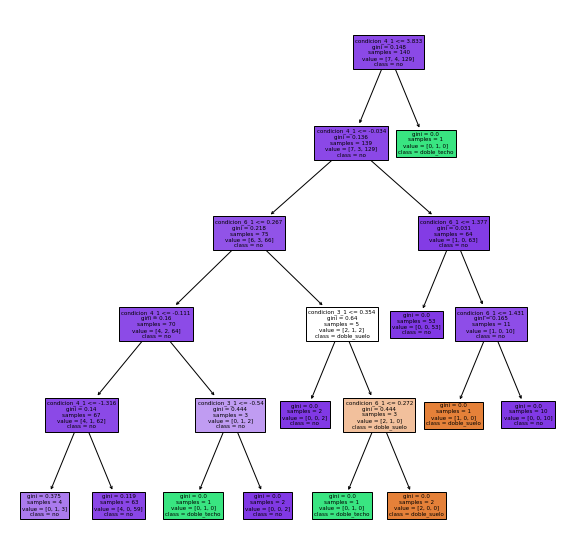

In [88]:
# 3.3.2. dTree. Primer algoritmo. Lo hago correr en el df_maestro_grupo_1


features = df_maestro_grupo_1.loc[:,df_maestro_grupo_1.columns[5:9]]
target = df_maestro_grupo_1.loc[:,df_maestro_grupo_1.columns[4]]

##############################
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,1,2,3]])
features.condicion_1 = features_2.condicion_1
features.condicion_3_1 = features_2.condicion_3_1
features.condicion_4_1 = features_2.condicion_4_1
features.condicion_6_1 = features_2.condicion_6_1
################


x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.4,
                                                    stratify=target.values)
vals, counts = np.unique(y_train, return_counts=True)
print(f'y_train: {dict(zip(vals, counts))}')
vals, counts = np.unique(y_test, return_counts=True)
print(f'y_test: {dict(zip(vals, counts))}')
dTree = DecisionTreeClassifier(max_depth=5)
_ = dTree.fit(x_train, y_train)
test_predicted = dTree.predict(x_test)
pd.DataFrame({'label': y_test, 
              'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')
print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']
scores = cross_validate(dTree, features, target, scoring=scoring, cv=4) # intenta con cv = 3
print('accuracy')
print(pd.DataFrame(scores))
print('accuracy_mean')
print(pd.DataFrame(scores).mean())


kfold = KFold(n_splits=4, shuffle=True)
acc = []
mejor_arbol = dTree ##############
i= 0 #########
mejor_modelo = 0 ############
mayor = 0 ####
features_arr = features.to_numpy()
for train, test in kfold.split(features_arr):
    
    fold_train_x = features_arr[train]
    fold_train_y = target[train]
    arbol = dTree.fit(fold_train_x, fold_train_y) #####################################arbol = 
    

    
    fold_test_x = features_arr[test]
    fold_test_y = target[test]
    
    i_acc = dTree.score(fold_test_x, fold_test_y)
    
    i_class = np.where(dTree.classes_ == 'doble_suelo')[0][0]
    print('class:', i_class)
    fold_test_pred = dTree.predict_proba(fold_test_x)[:,i_class]
    
    
    i_class = np.where(dTree.classes_ == 'doble_techo')[0][0]
    print('class:', i_class)
    fold_test_pred = dTree.predict_proba(fold_test_x)[:,i_class]
    acc.append(i_acc)
    
    #SALVO EL MODELO CON MAYOR i_acc que usare para seguir con el ejercicio
    if i_acc > mejor_modelo: ##########
        mejor_modelo = i_acc
        import copy
        mejor_arbol = copy.copy(arbol)
        mayor = i #########

    i= i+1 #########
    
result = pd.DataFrame({'accuracy':acc})
print('Resultados de KFold(n_splits=4, shuffle=True); absolutos:')
print(result)
print('Resultados de KFold(n_splits=4, shuffle=True); medias: ')
print(result.mean())

dTree_features = features
dTree_target = target
dTree_x_test = x_test
dTree_y_test = y_test



print(f'mayor:{mayor}')
print(f'mejor i_acc de las clases de este modelo es la numero:{mejor_modelo}')
print(mejor_arbol)
fig, ax = plt.subplots(figsize=(10,10)) #########
_ = plot_tree(mejor_arbol, feature_names=features.columns, #########
                        class_names=arbol.classes_, #########
                        filled=True) #########
mayor_dTree_orden = mayor ##########
mayor_dTree_iac = mejor_modelo ###############

In [92]:
# 3.3.3.  KNN. Segundo algoritmo. Lo hago correr en el df_maestro_grupo_2


features = df_maestro_grupo_2.loc[:,df_maestro_grupo_2.columns[5:9]]
target = df_maestro_grupo_2.loc[:,df_maestro_grupo_2.columns[4]]

##############################
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,1,2,3]])
features.condicion_2 = features_2.condicion_2
features.condicion_3_2 = features_2.condicion_3_2
features.condicion_5_1 = features_2.condicion_5_1
features.condicion_7_1 = features_2.condicion_7_1
################

x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.4,
                                                    stratify=target.values)
vals, counts = np.unique(y_train, return_counts=True)
print(f'y_train: {dict(zip(vals, counts))}')
vals, counts = np.unique(y_test, return_counts=True)
print(f'y_test: {dict(zip(vals, counts))}')



knn = KNeighborsClassifier(n_neighbors=5)
_ = knn.fit(x_train, y_train)
test_predicted = knn.predict(x_test)



print(knn.score(x_train, y_train))


pd.DataFrame({'label': y_test, 
              'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')

print('Matriz de Confusion')
print(matriz_confusion(y_test, test_predicted))

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']
scores = cross_validate(knn, features, target, scoring=scoring, cv=4)
print('accuracy')
print(pd.DataFrame(scores))
print('accuracy')
print(pd.DataFrame(scores).mean())


kfold = KFold(n_splits=4, shuffle=True)
acc = []
# auc = []


mejor_knn = knn ##################
mejor_modelo = 0 ##################
i = 0 ##################
mayor = 0 ##################

features_arr = features.to_numpy()
for train, test in kfold.split(features_arr):
    
    fold_train_x = features_arr[train]
    fold_train_y = target[train]
    knn_a_evaluar = knn.fit(fold_train_x, fold_train_y) ##################

    fold_test_x = features_arr[test]
    fold_test_y = target[test]

    i_acc = knn.score(fold_test_x, fold_test_y)
    
    i_class = np.where(knn.classes_ == 'doble_suelo')[0][0]
    print('class:', i_class)
    fold_test_pred = knn.predict_proba(fold_test_x)[:,i_class]


    i_class = np.where(knn.classes_ == 'doble_techo')[0][0]
    print('class:', i_class)
    fold_test_pred = knn.predict_proba(fold_test_x)[:,i_class]

    acc.append(i_acc)
    
    if i_acc > mejor_modelo: ##########
        mejor_modelo = i_acc ##################
        print(f'mejor i_acc de las clases de este modelo es la numero:{i_acc}')
        import copy ##################
        mejor_knn = copy.copy(knn_a_evaluar) ##############
        mayor = i #########
    i = i+1 ###########

result = pd.DataFrame({'accuracy':acc})
print('Resultados de KFold(n_splits=4, shuffle=True); absolutos:')
print(result)
print('Resultados de KFold(n_splits=4, shuffle=True); medias: ')
print(result.mean())


knn_features = features
knn_target = target
knn_x_test = x_test
knn_y_test = y_test

print(f'mayor i_acc es la clase:{mayor}') ###############
print(mejor_knn) ###################3

mayor_knn_orden = mayor ###############
print(f'mejor i_acc de las clases de este modelo es la numero:{mejor_modelo}') ###########
mayor_knn_iac = mejor_modelo ###############

y_train: {'doble_suelo': 6, 'doble_techo': 3, 'no': 103}
y_test: {'doble_suelo': 4, 'doble_techo': 2, 'no': 69}
0.9196428571428571
accuracy_score: 0.9066666666666666
Matriz de Confusi´on
Real         doble_suelo  doble_techo  no
Predicted                                
doble_suelo            0            0   1
no                     4            2  68
accuracy
   fit_time  score_time  test_accuracy
0  0.001957    0.003994       0.914894
1  0.003994    0.007996       0.914894
2  0.005004    0.005995       0.914894
3  0.002000    0.005998       0.934783
accuracy
fit_time         0.003239
score_time       0.005996
test_accuracy    0.919866
dtype: float64
class: 0
class: 1
mejor i_acc de las clases de este modelo es la numero:0.8936170212765957
class: 0
class: 1
mejor i_acc de las clases de este modelo es la numero:0.9148936170212766
class: 0
class: 1
mejor i_acc de las clases de este modelo es la numero:0.9787234042553191
class: 0
class: 1
Resultados de KFold(n_splits=4, shuffle=True); a

In [ ]:
# 3.4  y repetir el proceso para un n´umero peque˜no de iteraciones.

In [ ]:
# 3.4.1, para un segundo grupo de S'

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23260\1464547510.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_data['r_v'] = r_v
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23260\1464547510.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_data['Valor_Etiqueta'] = ejemplos_s.iloc[i,1]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23260\1464547510.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

y_train: {'doble_suelo': 6, 'doble_techo': 3, 'no': 133}
y_test: {'doble_suelo': 4, 'doble_techo': 2, 'no': 89}
accuracy_score: 0.8947368421052632
Matriz de Confusi´on
Real         doble_suelo  doble_techo  no
Predicted                                
doble_suelo            0            1   4
no                     4            1  85
accuracy
   fit_time  score_time  test_accuracy
0  0.002028    0.002000       0.883333
1  0.002006    0.000994       0.898305
2  0.001000    0.002001       0.847458
3  0.003000    0.001001       0.949153
accuracy_mean
fit_time         0.002008
score_time       0.001499
test_accuracy    0.894562
dtype: float64
class: 0
class: 1
class: 0
class: 1
class: 0
class: 1
class: 0
class: 1
Resultados de KFold(n_splits=4, shuffle=True); absolutos:
   accuracy
0  0.883333
1  0.898305
2  0.915254
3  0.932203
Resultados de KFold(n_splits=4, shuffle=True); medias: 
accuracy    0.907274
dtype: float64
mayor:3
mejor i_acc de las clases de este modelo es la numero:0.9322033

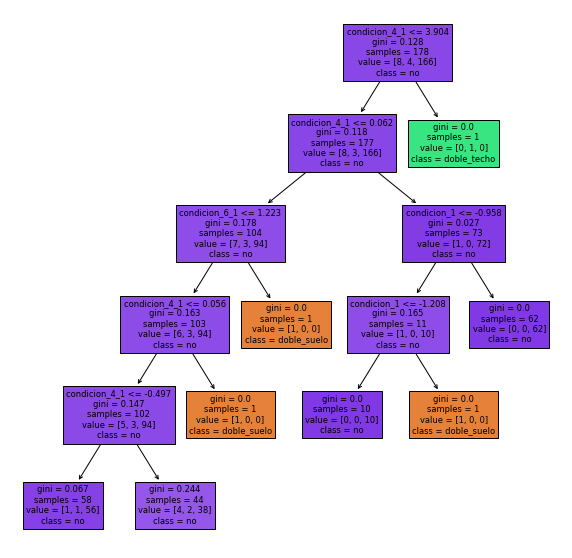

In [93]:
#"
# 2. Generar un conjunto S′ a etiquetar sacando ventanas aleatorias de la serie.
# 2.1 Genero un array de 50 prinicpios de ventana como inicializacion de S'
n= 50
df_data_ej_3 = ibex
etiquetas = np.zeros(n)
idfechas = np.zeros(n)
anterior = 0
final = 0
window = 50
for i in range(anterior, anterior + n):
    idx = np.random.randint(0, df_data_ej_3.shape[0] - window)
    idfechas[i] = idx
    windata = df_data_ej_3.iloc[idx:idx+window]
idfechas
# 2.2 Salvo en ejemplos_doble_suelo_doble_techo_test_nuevo_Ej3_S2.csv el conjunto de OHLC del IBEX que usare para S'
columnas= ['etiqueta']
doble_suelo_doble_techo_labels_3 = pd.DataFrame(etiquetas, index=df_data_ej_3.index[idfechas.astype(int)], columns =columnas)
doble_suelo_doble_techo_labels_3['idfechas'] = idfechas
doble_suelo_doble_techo_labels_3.to_csv('ejemplos_doble_suelo_doble_techo_test_nuevo_Ej3_S2.csv')   ###############S

# 2.2 extraigo el csv de etiquetado. Le quito los 3 aunque no deberia ser necesario
ejemplos_s = pd.read_csv('ejemplos_doble_suelo_doble_techo_test_nuevo_Ej3_S2.csv')  ###############S
ejemplos_s.columns = ['fecha','etiqueta','idfechas']
ejemplos_s

# 2.3 Genero las caracteriticas de este grupo S'
# aunque lo puedo hacer de otra forma que no sea haciendo los pkl, como lo he ido haciendo asi, pues sigo de la misma forma.

#2.3.1 guardo grupo S' un pkl con OHLC por con la etiqueta (0,1,2), numero de grafico y fecha de inicio de OHLC en string

for i in range(0,ejemplos_s.shape[0]):
    idx = df_data.index.get_loc(ejemplos_s.fecha.iloc[i])
    
    win_data = df_data.iloc[idx:idx+window]

    def retorno_ventana(data):
        r = data.close.iloc[-1]/data.close.iloc[0] - 1
        return r 
    r_v= retorno_ventana(win_data)
    win_data.head(), r_v
    win_data['r_v'] = r_v
    win_data['Valor_Etiqueta'] = ejemplos_s.iloc[i,1]
    win_data['Numero_Ejemplo'] = i
    win_data['Fecha_Inicio_Ejemplo'] = ejemplos_s.iloc[i,0]
    win_data['idfechas'] = ejemplos_s.iloc[i,2]

    with open(f'OHLC_pck_Ej_5_3_S2/{i}_OHLC_Ej5_3_S2.pkl', 'wb') as f: ###############S
        pickle.dump(win_data, f) 

# 2.3.2 Generar caracterısticas como en el ejercicio 2
columnas = ['Ejemplo_n','Primer_dia','Ultimo_dia','Valor_Etiqueta','condicion_1', 'condicion_2','condicion_3_1',
            'condicion_3_2','condicion_4_1','condicion_5_1', 'condicion_6_1','condicion_7_1']
df_data = ibex
df = pd.DataFrame(0, index=np.arange(n), columns = columnas)
df_data['lista'] =range(0,df_data.shape[0])
for i in range(0,ejemplos_s.shape[0]):

    with open(f'OHLC_pck_Ej_5_3_S2/{i}_OHLC_Ej5_3_S2.pkl', 'rb') as handle:  ###############S
        bm_aux = pickle.load(handle)

        columnas = ['close','high','low','open','vol','r_v','Valor_Etiqueta','Numero_Ejemplo','Fecha_Inicio_Ejemplo','idfechas']
        bm = pd.DataFrame( index = bm_aux.index, columns = columnas)
        bm.close = bm_aux.close
        bm.high = bm_aux.high
        bm.low= bm_aux.low
        bm.open = bm_aux.open
        bm.vol = bm_aux.vol
        bm.r_v = bm_aux.r_v
        bm.Valor_Etiqueta = bm_aux.Valor_Etiqueta
        bm.Numero_Ejemplo = bm_aux.Numero_Ejemplo
        bm.Fecha_Inicio_Ejemplo = bm_aux.Fecha_Inicio_Ejemplo
        bm.idfechas = bm_aux.idfechas

    a,b = preprocesamiento_scale(bm.iloc[:,0:4])
    bm.close = a.close
    bm.high = a.high
    bm.low = a.low
    bm.open = a.open


#  CONDICION_1
    MAX = bm.index[bm.high == bm.high.max()][0]
    MIN = bm.index[bm.low == bm.low.min()][0]
    condicion_1 =abs(int(df_data[df_data.index == MAX].lista.values) - int(df_data[df_data.index == MIN].lista.values))
    
#  CONDICION_2
    posicion_max = bm.index[bm.high == bm.high.max()][0] - bm.index[0]
    posicion_min = bm.index[bm.low == bm.low.min()] - bm.index[0]
    try:
        if (posicion_max > posicion_min):  
            condicion_2 = 1 #primero es en minimo
        else: 
            condicion_2 = 0 #primero es en maximo o el mismo dia

    except ValueError:
        condicion_2 = 1
    
   
#  CONDICION_3
    umbral = bm.open[0] * 0.05
    umbral_superior = bm.open[0] + umbral
    umbral_inferior =  bm.open[0] - umbral
    numero_de_veces_superar_maximo = 0
    numero_de_veces_superar_minimo = 0
    for i_2 in range(0,bm.shape[0]):
        if bm.high[i_2] > umbral_superior:
            numero_de_veces_superar_maximo = numero_de_veces_superar_maximo + 1
        if bm.low[i_2] < umbral_inferior:
            numero_de_veces_superar_minimo  = numero_de_veces_superar_minimo + 1
    condicion_3_1 = numero_de_veces_superar_maximo
    condicion_3_2 = numero_de_veces_superar_minimo
    
# • CONDICION_4_1: calculo la variacion de volumne del nivel mas bajo con respecto a la media de volumen del periodo
    condicion_4_1 = (bm.loc[bm.low == bm.low.min()]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))

# • CONDICION_5_1: calculo la variacion de volumne del segundo nivel mas bajo con respecto a la media de volumen del periodo
    lows = list(bm.low)
    lows.sort(reverse=False)
    condicion_5 = 0
    condicion_5_1 = (bm.loc[bm.low == lows[1]]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))    

# • CONDICION_6_1: calculo la variacion de volumne del nivel mas alto con respecto a la media de volumen del periodo
    condicion_6_1 = (bm.loc[bm.high == bm.high.min()]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))

# • CONDICION_7_1: calculo la variacion de volumne del segundo nivel mas bajo con respecto a la media de volumen del periodo
    high = list(bm.high)
    high.sort(reverse=True)
    condicion_7_1 = (bm.loc[bm.high == high[1]]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol'])) 


    columnas = ['Ejemplo_n','Valor_Etiqueta','condicion_1', 'condicion_2','condicion_3_1',
               'condicion_3_2','condicion_4','condicion_4_1','condicion_5','condicion_5_1']
    df.loc[i,'condicion_1'] = condicion_1
    df.loc[i,'condicion_2'] = condicion_2
    df.loc[i,'condicion_3_1'] = condicion_3_1
    df.loc[i,'condicion_3_2'] = condicion_3_2
    # df.loc[i,'condicion_4'] = condicion_4
    df.loc[i,'condicion_4_1'] = condicion_4_1
    # df.loc[i,'condicion_5'] = condicion_5
    df.loc[i,'condicion_5_1'] = condicion_5_1
    df.loc[i,'condicion_6_1'] = condicion_6_1
    df.loc[i,'condicion_7_1'] = condicion_7_1  
    df.loc[i,'Valor_Etiqueta'] = bm['Valor_Etiqueta'][0]
    df.loc[i,'Ejemplo_n'] = i    
    df.loc[i,'Primer_dia'] = bm.index[0].strftime('%Y-%m-%d')
    df.loc[i,'Ultimo_dia'] = bm.index[-1].strftime('%Y-%m-%d')
    ve= bm['Valor_Etiqueta'][0]
    pri_dia = bm.index[0].strftime('%Y-%m-%d')
    ult_dia = bm.index[-1].strftime('%Y-%m-%d')
df


# 2.3.3 guardo para luego subirlo un csv con el df maestro
# asi, si pasa algo con el programa lo puedo recuperar
df.to_csv('df_maestro_Ej_5_3_S2.csv') ##################################################RECUPARLO LUEGO  S
df_maestro_S = pd.read_csv('df_maestro_Ej_5_3_S2.csv', header=0)   ###############S
# etiquetas y condiciones las pongo mas descriptivas
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.astype(int)
df_maestro_S.condicion_1 = df_maestro_S.condicion_1.astype(int)
df_maestro_S.condicion_2 = df_maestro_S.condicion_2.astype(int)
df_maestro_S.condicion_3_1 = df_maestro_S.condicion_3_1.astype(int)
df_maestro_S.condicion_3_2 = df_maestro_S.condicion_3_2.astype(int)
df_maestro_S.condicion_4_1 = df_maestro_S.condicion_4_1.astype(float)
df_maestro_S.condicion_5_1 = df_maestro_S.condicion_5_1.astype(float)
df_maestro_S.condicion_6_1 = df_maestro_S.condicion_6_1.astype(float)
df_maestro_S.condicion_7_1 = df_maestro_S.condicion_7_1.astype(float)
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.replace(0, "no")
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.replace(1, "doble_suelo")
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.replace(2, "doble_techo")
df_maestro_S_original_sin_escalado = df_maestro.iloc[:,5:13]
df_maestro_S

# 2.3.4 Tomas explico que separaramos este S' en dos grupos como haciamos con el df_maestro del punto anterior 

#" 1.2.5 desarrollar un conjunto independiente de nuevas caracterısticas. Si se dispone 
# de mas de 5 caracterısticas se podr´ıan partir en 2 sub-conjuntos. 
# genero un df df_maestro_grupo_1 con 4 caracteriticas del df_maestro
# genero un df df_maestro_grupo_2 con 4 caracteriticas independientes a df_maestro_grupo_1 del df_maestro "

df_maestro_S_grupo_1 = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),0:5]
df_maestro_S_grupo_1['condicion_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),5]
df_maestro_S_grupo_1['condicion_3_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),7]
df_maestro_S_grupo_1['condicion_4_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),9]
df_maestro_S_grupo_1['condicion_6_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),11]
df_maestro_S_grupo_2 = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),0:5]
df_maestro_S_grupo_2['condicion_2'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),6]
df_maestro_S_grupo_2['condicion_3_2'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),8]
df_maestro_S_grupo_2['condicion_5_1'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),10]
df_maestro_S_grupo_2['condicion_7_1'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),12]


# 3. Entrenar dos modelos, uno con cada grupo de caracterısticas, y etiquetar un subconjunto S’ segun
# la clase con mayor conﬁanza en ambos modelos. Asumir ahora, que S’ etiquetado junto con las
# etiquetas iniciales es el nuevo conjunto de entrenamiento, y repetir el proceso para un numero
# pequeno de iteraciones.

# 3.1

# Para el grupo S1, uso el algoritmo mejor_arbol para predecir y poner el valor de etiqueta
s_1_predecir = df_maestro_S_grupo_1.loc[:,df_maestro_S_grupo_1.columns[5:9]]
test_predicted = mejor_arbol.predict(s_1_predecir)
df_maestro_S_grupo_1.Valor_Etiqueta = test_predicted
df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),4] = test_predicted


# Para el grupo S2, uso el algoritmo mejor_knn para predecir y poner el valor de etiqueta
s_2_predecir = df_maestro_S_grupo_2.loc[:,df_maestro_S_grupo_2.columns[5:9]]
test_predicted = mejor_knn.predict(s_2_predecir)
df_maestro_S_grupo_2.Valor_Etiqueta = test_predicted
df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),4]= test_predicted


df_maestro_S

# 3.2 Asumir ahora, que S’ etiquetado junto con las etiquetas iniciales es el nuevo conjunto de entrenamiento, 
# uno el df_maestro y df_maestro_S en un df_maestro
df_maestro = pd.concat([df_maestro, df_maestro_S], axis=0)
df_maestro.Ejemplo_n = range(0,df_maestro.shape[0])
df_maestro.index = range(0,df_maestro.shape[0])
df_maestro.shape

# 3.3 Calculo sobre este nuevo set de df_maestro el mejor_arbol y el mejor_knn para usarlo para estimar la proxima iteracion

df_maestro_grupo_1 = df_maestro.iloc[:,0:5]
df_maestro_grupo_1['condicion_1'] = df_maestro.condicion_1
df_maestro_grupo_1['condicion_3_1'] = df_maestro.condicion_3_1
df_maestro_grupo_1['condicion_4_1'] = df_maestro.condicion_4_1
df_maestro_grupo_1['condicion_6_1'] = df_maestro.condicion_6_1


df_maestro_grupo_2 = df_maestro.iloc[:,0:5]
df_maestro_grupo_2['condicion_2'] = df_maestro.condicion_2
df_maestro_grupo_2['condicion_3_2'] = df_maestro.condicion_3_2
df_maestro_grupo_2['condicion_5_1'] = df_maestro.condicion_5_1
df_maestro_grupo_2['condicion_7_1'] = df_maestro.condicion_7_1



# 3.3.2. dTree. Primer algoritmo. Lo hago correr en el df_maestro_grupo_1


features = df_maestro_grupo_1.loc[:,df_maestro_grupo_1.columns[5:9]]
target = df_maestro_grupo_1.loc[:,df_maestro_grupo_1.columns[4]]

##############################
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,1,2,3]])

features.condicion_1 = features_2.condicion_1
features.condicion_3_1 = features_2.condicion_3_1

features.condicion_4_1 = features_2.condicion_4_1

features.condicion_6_1 = features_2.condicion_6_1

################


x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.4,
                                                    stratify=target.values)
vals, counts = np.unique(y_train, return_counts=True)
print(f'y_train: {dict(zip(vals, counts))}')
vals, counts = np.unique(y_test, return_counts=True)
print(f'y_test: {dict(zip(vals, counts))}')
dTree = DecisionTreeClassifier(max_depth=5)
_ = dTree.fit(x_train, y_train)
test_predicted = dTree.predict(x_test)
pd.DataFrame({'label': y_test, 
              'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')
print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']
scores = cross_validate(dTree, features, target, scoring=scoring, cv=4) # intenta con cv = 3
print('accuracy')
print(pd.DataFrame(scores))
print('accuracy_mean')
print(pd.DataFrame(scores).mean())


kfold = KFold(n_splits=4, shuffle=True)
acc = []
mejor_arbol = dTree ##############
i= 0 #########
mejor_modelo = 0 ############
mayor = 0 ####
features_arr = features.to_numpy()
for train, test in kfold.split(features_arr):
    
    fold_train_x = features_arr[train]
    fold_train_y = target[train]
    arbol = dTree.fit(fold_train_x, fold_train_y) #####################################arbol = 
    

    
    fold_test_x = features_arr[test]
    fold_test_y = target[test]
    
    i_acc = dTree.score(fold_test_x, fold_test_y)
    
    i_class = np.where(dTree.classes_ == 'doble_suelo')[0][0]
    print('class:', i_class)
    fold_test_pred = dTree.predict_proba(fold_test_x)[:,i_class]
    
    
    i_class = np.where(dTree.classes_ == 'doble_techo')[0][0]
    print('class:', i_class)
    fold_test_pred = dTree.predict_proba(fold_test_x)[:,i_class]
    acc.append(i_acc)
    
    #SALVO EL MODELO CON MAYOR i_acc que usare para seguir con el ejercicio
    if i_acc > mejor_modelo: ##########
        mejor_modelo = i_acc
        #mejor_arbol = arbol ########## es pq asigna
        import copy
        mejor_arbol = copy.copy(arbol)
        mayor = i #########

    i= i+1 #########
    
result = pd.DataFrame({'accuracy':acc})
print('Resultados de KFold(n_splits=4, shuffle=True); absolutos:')
print(result)
print('Resultados de KFold(n_splits=4, shuffle=True); medias: ')
print(result.mean())

dTree_features = features
dTree_target = target
dTree_x_test = x_test
dTree_y_test = y_test



print(f'mayor:{mayor}')
print(f'mejor i_acc de las clases de este modelo es la numero:{mejor_modelo}')
print(mejor_arbol)
fig, ax = plt.subplots(figsize=(10,10)) #########
_ = plot_tree(mejor_arbol, feature_names=features.columns, #########
                        class_names=arbol.classes_, #########
                        filled=True) #########
mayor_dTree_orden = mayor ##########
mayor_dTree_iac = mejor_modelo ###############

# 3.3.3.  KNN. Segundo algoritmo. Lo hago correr en el df_maestro_grupo_2


features = df_maestro_grupo_2.loc[:,df_maestro_grupo_2.columns[5:9]]
target = df_maestro_grupo_2.loc[:,df_maestro_grupo_2.columns[4]]

##############################
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,1,2,3]])
features.condicion_2 = features_2.condicion_2
features.condicion_3_2 = features_2.condicion_3_2
features.condicion_5_1 = features_2.condicion_5_1
features.condicion_7_1 = features_2.condicion_7_1
################

x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.4,
                                                    stratify=target.values)
vals, counts = np.unique(y_train, return_counts=True)
print(f'y_train: {dict(zip(vals, counts))}')
vals, counts = np.unique(y_test, return_counts=True)
print(f'y_test: {dict(zip(vals, counts))}')



knn = KNeighborsClassifier(n_neighbors=5)
_ = knn.fit(x_train, y_train)
test_predicted = knn.predict(x_test)



print(knn.score(x_train, y_train))

pd.DataFrame({'label': y_test, 
              'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')

print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']
scores = cross_validate(knn, features, target, scoring=scoring, cv=4) # poner cv= 3 para queitar el warning
print('accuracy') # y roc_auc:')
print(pd.DataFrame(scores))
print('accuracy')#  y roc_auc MEANs:')
print(pd.DataFrame(scores).mean())


kfold = KFold(n_splits=4, shuffle=True)
acc = []
# auc = []


mejor_knn = knn ##################
mejor_modelo = 0 ##################
i = 0 ##################
mayor = 0 ##################

features_arr = features.to_numpy()
for train, test in kfold.split(features_arr):
    
    fold_train_x = features_arr[train]
    fold_train_y = target[train]
    knn_a_evaluar = knn.fit(fold_train_x, fold_train_y) ##################

    fold_test_x = features_arr[test]
    fold_test_y = target[test]

    i_acc = knn.score(fold_test_x, fold_test_y)
    
    i_class = np.where(knn.classes_ == 'doble_suelo')[0][0]
    print('class:', i_class)
    fold_test_pred = knn.predict_proba(fold_test_x)[:,i_class]


    i_class = np.where(knn.classes_ == 'doble_techo')[0][0]
    print('class:', i_class)
    fold_test_pred = knn.predict_proba(fold_test_x)[:,i_class]

    acc.append(i_acc)
    
    if i_acc > mejor_modelo: ##########
        mejor_modelo = i_acc ##################
        print(f'mejor i_acc de las clases de este modelo es la numero:{i_acc}')
        import copy ##################
        mejor_knn = copy.copy(knn_a_evaluar) ##############
        mayor = i #########
    i = i+1 ###########

result = pd.DataFrame({'accuracy':acc})
print('Resultados de KFold(n_splits=4, shuffle=True); absolutos:')
print(result)
print('Resultados de KFold(n_splits=4, shuffle=True); medias: ')
print(result.mean())


knn_features = features
knn_target = target
knn_x_test = x_test
knn_y_test = y_test

print(f'mayor i_acc es la clase:{mayor}') ###############
print(mejor_knn) ###################3

mayor_knn_orden = mayor ###############
print(f'mejor i_acc de las clases de este modelo es la numero:{mejor_modelo}') ###########
mayor_knn_iac = mejor_modelo ###############
#"

In [94]:
df_maestro

,Unnamed: 0,Ejemplo_n,Primer_dia,Ultimo_dia,Valor_Etiqueta,condicion_1,condicion_2,condicion_3_1,condicion_3_2,condicion_4_1,condicion_5_1,condicion_6_1,condicion_7_1
0,0,0,2008-02-29,2008-05-13,doble_suelo,48,1,50,2,0.113237,0.515546,0.113237,0.170791
1,1,1,2007-11-19,2008-02-01,no,13,0,4,42,-0.384593,-0.324094,-0.361012,0.020604
2,2,2,2018-07-11,2018-09-18,no,42,0,0,50,0.166753,0.041905,0.166753,0.461907
3,3,3,2007-01-10,2007-03-20,doble_suelo,33,1,49,2,0.167837,0.100248,0.167837,0.420954
4,4,4,2017-05-29,2017-08-04,doble_suelo,19,0,27,20,-0.003635,-0.068074,-0.227245,-0.300109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,45,232,2019-03-21,2019-06-03,no,28,0,20,30,-0.035748,0.288202,-0.035748,0.020315
233,46,233,2003-07-23,2003-10-01,no,15,0,44,6,0.589001,0.271260,0.271260,0.371145
234,47,234,2008-07-10,2008-09-17,no,26,0,11,39,0.593599,1.304575,1.304575,-0.356479
235,48,235,2010-10-18,2010-12-27,no,30,0,4,42,0.592994,0.466810,0.592994,-0.382899


In [101]:
# En ls ultimso 50; ha predicho todo 'No'. Puede ser; pero es raro.
df_maestro.Valor_Etiqueta[df_maestro.shape[0]-50: df_maestro.shape[0] ].values

array(['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no'], dtype=object)

In [ ]:
#3.4.2, para un tercero grupo de S'

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23260\1334677338.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_data['r_v'] = r_v
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23260\1334677338.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_data['Valor_Etiqueta'] = ejemplos_s.iloc[i,1]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23260\1334677338.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

y_train: {'doble_suelo': 7, 'doble_techo': 3, 'no': 162}
y_test: {'doble_suelo': 4, 'doble_techo': 2, 'no': 109}
accuracy_score: 0.9130434782608695
Matriz de Confusi´on
Real         doble_suelo  doble_techo   no
Predicted                                 
doble_suelo            0            0    4
no                     4            2  105
accuracy
   fit_time  score_time  test_accuracy
0  0.005003    0.006003       0.916667
1  0.004003    0.000993       0.888889
2  0.004001    0.002997       0.930556
3  0.005000    0.002999       0.943662
accuracy_mean
fit_time         0.004501
score_time       0.003248
test_accuracy    0.919943
dtype: float64
class: 0
class: 1
class: 0
class: 1
class: 0
class: 1
class: 0
class: 1
Resultados de KFold(n_splits=4, shuffle=True); absolutos:
   accuracy
0  0.902778
1  0.916667
2  0.916667
3  0.915493
Resultados de KFold(n_splits=4, shuffle=True); medias: 
accuracy    0.912901
dtype: float64
mayor:1
mejor i_acc de las clases de este modelo es la numero:0.91

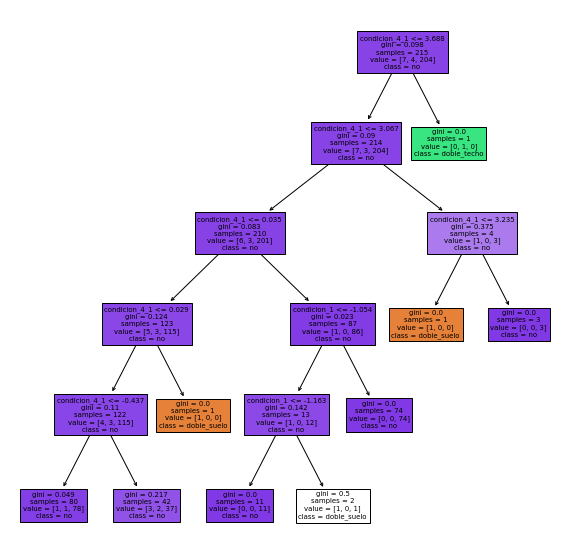

In [103]:
#"
# 2. Generar un conjunto S′ a etiquetar sacando ventanas aleatorias de la serie.
# 2.1 Genero un array de 50 prinicpios de ventana como inicializacion de S'
n= 50
df_data_ej_3 = ibex
etiquetas = np.zeros(n)
idfechas = np.zeros(n)
anterior = 0
final = 0
window = 50
for i in range(anterior, anterior + n):
    idx = np.random.randint(0, df_data_ej_3.shape[0] - window)
    idfechas[i] = idx
    windata = df_data_ej_3.iloc[idx:idx+window]
idfechas
# 2.2 Salvo en ejemplos_doble_suelo_doble_techo_test_nuevo_Ej3_S2.csv el conjunto de OHLC del IBEX que usare para S'
columnas= ['etiqueta']
doble_suelo_doble_techo_labels_3 = pd.DataFrame(etiquetas, index=df_data_ej_3.index[idfechas.astype(int)], columns =columnas)
doble_suelo_doble_techo_labels_3['idfechas'] = idfechas
doble_suelo_doble_techo_labels_3.to_csv('ejemplos_doble_suelo_doble_techo_test_nuevo_Ej3_S3.csv')   ###############S

# 2.2 extraigo el csv de etiquetado. Le quito los 3 aunque no deberia ser necesario
ejemplos_s = pd.read_csv('ejemplos_doble_suelo_doble_techo_test_nuevo_Ej3_S3.csv')  ###############S
ejemplos_s.columns = ['fecha','etiqueta','idfechas']
ejemplos_s

# 2.3 Genero las caracteriticas de este grupo S'
# aunque lo puedo hacer de otra forma que no sea haciendo los pkl, como lo he ido haciendo asi, pues sigo de la misma forma.

#2.3.1 guardo grupo S' un pkl con OHLC por con la etiqueta (0,1,2), numero de grafico y fecha de inicio de OHLC en string

for i in range(0,ejemplos_s.shape[0]):
    idx = df_data.index.get_loc(ejemplos_s.fecha.iloc[i])
    
    win_data = df_data.iloc[idx:idx+window]

    def retorno_ventana(data):
        r = data.close.iloc[-1]/data.close.iloc[0] - 1
        return r 
    r_v= retorno_ventana(win_data)
    win_data.head(), r_v
    win_data['r_v'] = r_v
    win_data['Valor_Etiqueta'] = ejemplos_s.iloc[i,1]
    win_data['Numero_Ejemplo'] = i
    win_data['Fecha_Inicio_Ejemplo'] = ejemplos_s.iloc[i,0]
    win_data['idfechas'] = ejemplos_s.iloc[i,2]

    with open(f'OHLC_pck_Ej_5_3_S3/{i}_OHLC_Ej5_3_S3.pkl', 'wb') as f: ###############S
        pickle.dump(win_data, f) 

# 2.3.2 Generar caracterısticas como en el ejercicio 2
columnas = ['Ejemplo_n','Primer_dia','Ultimo_dia','Valor_Etiqueta','condicion_1', 'condicion_2','condicion_3_1',
            'condicion_3_2','condicion_4_1','condicion_5_1', 'condicion_6_1','condicion_7_1']
df_data = ibex
df = pd.DataFrame(0, index=np.arange(n), columns = columnas)
df_data['lista'] =range(0,df_data.shape[0])
for i in range(0,ejemplos_s.shape[0]):

    with open(f'OHLC_pck_Ej_5_3_S3/{i}_OHLC_Ej5_3_S3.pkl', 'rb') as handle:  ###############S
        bm_aux = pickle.load(handle)

        columnas = ['close','high','low','open','vol','r_v','Valor_Etiqueta','Numero_Ejemplo','Fecha_Inicio_Ejemplo','idfechas']
        bm = pd.DataFrame( index = bm_aux.index, columns = columnas)
        bm.close = bm_aux.close
        bm.high = bm_aux.high
        bm.low= bm_aux.low
        bm.open = bm_aux.open
        bm.vol = bm_aux.vol
        bm.r_v = bm_aux.r_v
        bm.Valor_Etiqueta = bm_aux.Valor_Etiqueta
        bm.Numero_Ejemplo = bm_aux.Numero_Ejemplo
        bm.Fecha_Inicio_Ejemplo = bm_aux.Fecha_Inicio_Ejemplo
        bm.idfechas = bm_aux.idfechas

    a,b = preprocesamiento_scale(bm.iloc[:,0:4])
    bm.close = a.close
    bm.high = a.high
    bm.low = a.low
    bm.open = a.open


#  CONDICION_1
    MAX = bm.index[bm.high == bm.high.max()][0]
    MIN = bm.index[bm.low == bm.low.min()][0]

    condicion_1 =abs(int(df_data[df_data.index == MAX].lista.values) - int(df_data[df_data.index == MIN].lista.values))
    
#  CONDICION_2
    posicion_max = bm.index[bm.high == bm.high.max()][0] - bm.index[0]
    posicion_min = bm.index[bm.low == bm.low.min()] - bm.index[0]
    try:
        if (posicion_max > posicion_min):  
            condicion_2 = 1 #primero es en minimo
        else: 
            condicion_2 = 0 #primero es en maximo o el mismo dia

    except ValueError:
        condicion_2 = 1
    
   
#  CONDICION_3
    umbral = bm.open[0] * 0.05
    umbral_superior = bm.open[0] + umbral
    umbral_inferior =  bm.open[0] - umbral
    numero_de_veces_superar_maximo = 0
    numero_de_veces_superar_minimo = 0
    for i_2 in range(0,bm.shape[0]):
        if bm.high[i_2] > umbral_superior:
            numero_de_veces_superar_maximo = numero_de_veces_superar_maximo + 1
        if bm.low[i_2] < umbral_inferior:
            numero_de_veces_superar_minimo  = numero_de_veces_superar_minimo + 1
    condicion_3_1 = numero_de_veces_superar_maximo
    condicion_3_2 = numero_de_veces_superar_minimo
    
# • CONDICION_4_1: calculo la variacion de volumne del nivel mas bajo con respecto a la media de volumen del periodo
    condicion_4_1 = (bm.loc[bm.low == bm.low.min()]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))

# • CONDICION_5_1: calculo la variacion de volumne del segundo nivel mas bajo con respecto a la media de volumen del periodo
    lows = list(bm.low)
    lows.sort(reverse=False)
    condicion_5 = 0
    condicion_5_1 = (bm.loc[bm.low == lows[1]]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))    

# • CONDICION_6_1: calculo la variacion de volumne del nivel mas alto con respecto a la media de volumen del periodo
    condicion_6_1 = (bm.loc[bm.high == bm.high.min()]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol']))

# • CONDICION_7_1: calculo la variacion de volumne del segundo nivel mas bajo con respecto a la media de volumen del periodo
    high = list(bm.high)
    high.sort(reverse=True)
    condicion_7_1 = (bm.loc[bm.high == high[1]]['vol'][0] - np.mean(bm['vol']))/(np.mean(bm['vol'])) 


    columnas = ['Ejemplo_n','Valor_Etiqueta','condicion_1', 'condicion_2','condicion_3_1',
               'condicion_3_2','condicion_4','condicion_4_1','condicion_5','condicion_5_1']
    df.loc[i,'condicion_1'] = condicion_1
    df.loc[i,'condicion_2'] = condicion_2
    df.loc[i,'condicion_3_1'] = condicion_3_1
    df.loc[i,'condicion_3_2'] = condicion_3_2
    # df.loc[i,'condicion_4'] = condicion_4
    df.loc[i,'condicion_4_1'] = condicion_4_1
    # df.loc[i,'condicion_5'] = condicion_5
    df.loc[i,'condicion_5_1'] = condicion_5_1
    df.loc[i,'condicion_6_1'] = condicion_6_1
    df.loc[i,'condicion_7_1'] = condicion_7_1  
    df.loc[i,'Valor_Etiqueta'] = bm['Valor_Etiqueta'][0]
    df.loc[i,'Ejemplo_n'] = i    
    df.loc[i,'Primer_dia'] = bm.index[0].strftime('%Y-%m-%d')
    df.loc[i,'Ultimo_dia'] = bm.index[-1].strftime('%Y-%m-%d')
    ve= bm['Valor_Etiqueta'][0]
    pri_dia = bm.index[0].strftime('%Y-%m-%d')
    ult_dia = bm.index[-1].strftime('%Y-%m-%d')
df


# 2.3.3 guardo para luego subirlo un csv con el df maestro
# asi, si pasa algo con el programa lo puedo recuperar
df.to_csv('df_maestro_Ej_5_3_S2.csv') ##################################################RECUPARLO LUEGO  S
df_maestro_S = pd.read_csv('df_maestro_Ej_5_3_S2.csv', header=0)   ###############S
# etiquetas y condiciones las pongo mas descriptivas
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.astype(int)
df_maestro_S.condicion_1 = df_maestro_S.condicion_1.astype(int)
df_maestro_S.condicion_2 = df_maestro_S.condicion_2.astype(int)
df_maestro_S.condicion_3_1 = df_maestro_S.condicion_3_1.astype(int)
df_maestro_S.condicion_3_2 = df_maestro_S.condicion_3_2.astype(int)
df_maestro_S.condicion_4_1 = df_maestro_S.condicion_4_1.astype(float)
df_maestro_S.condicion_5_1 = df_maestro_S.condicion_5_1.astype(float)
df_maestro_S.condicion_6_1 = df_maestro_S.condicion_6_1.astype(float)
df_maestro_S.condicion_7_1 = df_maestro_S.condicion_7_1.astype(float)
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.replace(0, "no")
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.replace(1, "doble_suelo")
df_maestro_S.Valor_Etiqueta = df_maestro_S.Valor_Etiqueta.replace(2, "doble_techo")
df_maestro_S_original_sin_escalado = df_maestro.iloc[:,5:13]
df_maestro_S

# 2.3.4 Tomas explico que separaramos este S' en dos grupos como haciamos con el df_maestro del punto anterior 

#" 1.2.5 desarrollar un conjunto independiente de nuevas caracterısticas. Si se dispone 
# de mas de 5 caracterısticas se podr´ıan partir en 2 sub-conjuntos. 
# genero un df df_maestro_grupo_1 con 4 caracteriticas del df_maestro
# genero un df df_maestro_grupo_2 con 4 caracteriticas independientes a df_maestro_grupo_1 del df_maestro "

df_maestro_S_grupo_1 = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),0:5]
df_maestro_S_grupo_1['condicion_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),5]
df_maestro_S_grupo_1['condicion_3_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),7]
df_maestro_S_grupo_1['condicion_4_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),9]
df_maestro_S_grupo_1['condicion_6_1'] = df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),11]
df_maestro_S_grupo_2 = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),0:5]
df_maestro_S_grupo_2['condicion_2'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),6]
df_maestro_S_grupo_2['condicion_3_2'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),8]
df_maestro_S_grupo_2['condicion_5_1'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),10]
df_maestro_S_grupo_2['condicion_7_1'] = df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),12]


# 3. Entrenar dos modelos, uno con cada grupo de caracterısticas, y etiquetar un subconjunto S’ segun
# la clase con mayor conﬁanza en ambos modelos. Asumir ahora, que S’ etiquetado junto con las
# etiquetas iniciales es el nuevo conjunto de entrenamiento, y repetir el proceso para un numero
# pequeno de iteraciones.

# 3.1

# Para el grupo S1, uso el algoritmo mejor_arbol para predecir y poner el valor de etiqueta
s_1_predecir = df_maestro_S_grupo_1.loc[:,df_maestro_S_grupo_1.columns[5:9]]
test_predicted = mejor_arbol.predict(s_1_predecir)
df_maestro_S_grupo_1.Valor_Etiqueta = test_predicted
df_maestro_S.iloc[0:int(df_maestro_S.shape[0]/2),4] = test_predicted


# Para el grupo S2, uso el algoritmo mejor_knn para predecir y poner el valor de etiqueta
s_2_predecir = df_maestro_S_grupo_2.loc[:,df_maestro_S_grupo_2.columns[5:9]]
test_predicted = mejor_knn.predict(s_2_predecir)
df_maestro_S_grupo_2.Valor_Etiqueta = test_predicted
df_maestro_S.iloc[int(df_maestro_S.shape[0]/2):int(df_maestro_S.shape[0]),4]= test_predicted


df_maestro_S

# 3.2 Asumir ahora, que S’ etiquetado junto con las etiquetas iniciales es el nuevo conjunto de entrenamiento, 
# uno el df_maestro y df_maestro_S en un df_maestro
df_maestro = pd.concat([df_maestro, df_maestro_S], axis=0)
df_maestro.Ejemplo_n = range(0,df_maestro.shape[0])
df_maestro.index = range(0,df_maestro.shape[0])
df_maestro.shape

# 3.3 Calculo sobre este nuevo set de df_maestro el mejor_arbol y el mejor_knn para usarlo para estimar la proxima iteracion

df_maestro_grupo_1 = df_maestro.iloc[:,0:5]
df_maestro_grupo_1['condicion_1'] = df_maestro.condicion_1
df_maestro_grupo_1['condicion_3_1'] = df_maestro.condicion_3_1
df_maestro_grupo_1['condicion_4_1'] = df_maestro.condicion_4_1
df_maestro_grupo_1['condicion_6_1'] = df_maestro.condicion_6_1


df_maestro_grupo_2 = df_maestro.iloc[:,0:5]
df_maestro_grupo_2['condicion_2'] = df_maestro.condicion_2
df_maestro_grupo_2['condicion_3_2'] = df_maestro.condicion_3_2
df_maestro_grupo_2['condicion_5_1'] = df_maestro.condicion_5_1
df_maestro_grupo_2['condicion_7_1'] = df_maestro.condicion_7_1



# 3.3.2. dTree. Primer algoritmo. Lo hago correr en el df_maestro_grupo_1


features = df_maestro_grupo_1.loc[:,df_maestro_grupo_1.columns[5:9]]
target = df_maestro_grupo_1.loc[:,df_maestro_grupo_1.columns[4]]

##############################
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,1,2,3]])

features.condicion_1 = features_2.condicion_1
features.condicion_3_1 = features_2.condicion_3_1

features.condicion_4_1 = features_2.condicion_4_1

features.condicion_6_1 = features_2.condicion_6_1

################


x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.4,
                                                    stratify=target.values)
vals, counts = np.unique(y_train, return_counts=True)
print(f'y_train: {dict(zip(vals, counts))}')
vals, counts = np.unique(y_test, return_counts=True)
print(f'y_test: {dict(zip(vals, counts))}')
dTree = DecisionTreeClassifier(max_depth=5)
_ = dTree.fit(x_train, y_train)

test_predicted = dTree.predict(x_test)
pd.DataFrame({'label': y_test, 
              'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')
print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']
scores = cross_validate(dTree, features, target, scoring=scoring, cv=4) # intenta con cv = 3
print('accuracy')
print(pd.DataFrame(scores))
print('accuracy_mean')
print(pd.DataFrame(scores).mean())


kfold = KFold(n_splits=4, shuffle=True)
acc = []

mejor_arbol = dTree ##############
i= 0 #########
mejor_modelo = 0 ############
mayor = 0 ####
features_arr = features.to_numpy()
for train, test in kfold.split(features_arr):
    
    fold_train_x = features_arr[train]
    fold_train_y = target[train]
    arbol = dTree.fit(fold_train_x, fold_train_y) #####################################arbol = 
    

    
    fold_test_x = features_arr[test]
    fold_test_y = target[test]
    
    i_acc = dTree.score(fold_test_x, fold_test_y)
    
    i_class = np.where(dTree.classes_ == 'doble_suelo')[0][0]
    print('class:', i_class)
    fold_test_pred = dTree.predict_proba(fold_test_x)[:,i_class]
    
    
    i_class = np.where(dTree.classes_ == 'doble_techo')[0][0]
    print('class:', i_class)
    fold_test_pred = dTree.predict_proba(fold_test_x)[:,i_class]
    acc.append(i_acc)
    
    #SALVO EL MODELO CON MAYOR i_acc que usare para seguir con el ejercicio
    # print(f'IAC:{i_acc}') #############
    if i_acc > mejor_modelo: ##########
        mejor_modelo = i_acc
        import copy
        mejor_arbol = copy.copy(arbol)
        mayor = i #########

    i= i+1 #########
    
result = pd.DataFrame({'accuracy':acc})
print('Resultados de KFold(n_splits=4, shuffle=True); absolutos:')
print(result)
print('Resultados de KFold(n_splits=4, shuffle=True); medias: ')
print(result.mean())

dTree_features = features
dTree_target = target
dTree_x_test = x_test
dTree_y_test = y_test



print(f'mayor:{mayor}')
print(f'mejor i_acc de las clases de este modelo es la numero:{mejor_modelo}')
print(mejor_arbol)
fig, ax = plt.subplots(figsize=(10,10)) #########
_ = plot_tree(mejor_arbol, feature_names=features.columns, #########
                        class_names=arbol.classes_, #########
                        filled=True) #########
mayor_dTree_orden = mayor ##########
mayor_dTree_iac = mejor_modelo ###############

# 3.3.3.  KNN. Segundo algoritmo. Lo hago correr en el df_maestro_grupo_2


features = df_maestro_grupo_2.loc[:,df_maestro_grupo_2.columns[5:9]]
target = df_maestro_grupo_2.loc[:,df_maestro_grupo_2.columns[4]]

##############################
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,1,2,3]])
features.condicion_2 = features_2.condicion_2
features.condicion_3_2 = features_2.condicion_3_2
features.condicion_5_1 = features_2.condicion_5_1
features.condicion_7_1 = features_2.condicion_7_1
################

x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.4,
                                                    stratify=target.values)
vals, counts = np.unique(y_train, return_counts=True)
print(f'y_train: {dict(zip(vals, counts))}')
vals, counts = np.unique(y_test, return_counts=True)
print(f'y_test: {dict(zip(vals, counts))}')



knn = KNeighborsClassifier(n_neighbors=5)
_ = knn.fit(x_train, y_train)
test_predicted = knn.predict(x_test)



print(knn.score(x_train, y_train))

pd.DataFrame({'label': y_test, 
              'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')

print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']
scores = cross_validate(knn, features, target, scoring=scoring, cv=4) # poner cv= 3 para queitar el warning
print('accuracy') # y roc_auc:')
print(pd.DataFrame(scores))
print('accuracy')#  y roc_auc MEANs:')
print(pd.DataFrame(scores).mean())


kfold = KFold(n_splits=4, shuffle=True)
acc = []
# auc = []


mejor_knn = knn ##################
mejor_modelo = 0 ##################
i = 0 ##################
mayor = 0 ##################

features_arr = features.to_numpy()
for train, test in kfold.split(features_arr):
    
    fold_train_x = features_arr[train]
    fold_train_y = target[train]
    knn_a_evaluar = knn.fit(fold_train_x, fold_train_y) ##################

    fold_test_x = features_arr[test]
    fold_test_y = target[test]

    i_acc = knn.score(fold_test_x, fold_test_y)
    
    i_class = np.where(knn.classes_ == 'doble_suelo')[0][0]
    print('class:', i_class)
    fold_test_pred = knn.predict_proba(fold_test_x)[:,i_class]


    i_class = np.where(knn.classes_ == 'doble_techo')[0][0]
    print('class:', i_class)
    fold_test_pred = knn.predict_proba(fold_test_x)[:,i_class]

    acc.append(i_acc)
    
    if i_acc > mejor_modelo: ##########
        mejor_modelo = i_acc ##################
        print(f'mejor i_acc de las clases de este modelo es la numero:{i_acc}')
        import copy ##################
        mejor_knn = copy.copy(knn_a_evaluar) ##############
        mayor = i #########
    i = i+1 ###########

result = pd.DataFrame({'accuracy':acc})
print('Resultados de KFold(n_splits=4, shuffle=True); absolutos:')
print(result)
print('Resultados de KFold(n_splits=4, shuffle=True); medias: ')
print(result.mean())


knn_features = features
knn_target = target
knn_x_test = x_test
knn_y_test = y_test

print(f'mayor i_acc es la clase:{mayor}') ###############
print(mejor_knn) ###################3

mayor_knn_orden = mayor ###############
print(f'mejor i_acc de las clases de este modelo es la numero:{mejor_modelo}') ###########
mayor_knn_iac = mejor_modelo ###############
#"

In [104]:
#3.4 Evaluo resultados en general
df_maestro

,Unnamed: 0,Ejemplo_n,Primer_dia,Ultimo_dia,Valor_Etiqueta,condicion_1,condicion_2,condicion_3_1,condicion_3_2,condicion_4_1,condicion_5_1,condicion_6_1,condicion_7_1
0,0,0,2008-02-29,2008-05-13,doble_suelo,48,1,50,2,0.113237,0.515546,0.113237,0.170791
1,1,1,2007-11-19,2008-02-01,no,13,0,4,42,-0.384593,-0.324094,-0.361012,0.020604
2,2,2,2018-07-11,2018-09-18,no,42,0,0,50,0.166753,0.041905,0.166753,0.461907
3,3,3,2007-01-10,2007-03-20,doble_suelo,33,1,49,2,0.167837,0.100248,0.167837,0.420954
4,4,4,2017-05-29,2017-08-04,doble_suelo,19,0,27,20,-0.003635,-0.068074,-0.227245,-0.300109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,45,282,2005-02-11,2005-04-25,no,42,0,11,41,0.662759,-0.050761,0.662759,0.117498
283,46,283,2009-08-25,2009-11-02,no,37,1,47,4,0.104786,-0.118250,-0.118250,0.558481
284,47,284,2005-03-01,2005-05-11,no,28,0,8,40,0.724234,-0.024762,-0.024762,-0.038587
285,48,285,2017-02-27,2017-05-10,no,47,1,49,2,-0.308059,-0.005311,-0.308059,0.294830


In [105]:
# En los ultimso 50; ha predicho todo 'doble_suelo'. Asi que algo funciona. Entondes la celda anerior de la iteracion 2 funcionaba tambien
df_maestro.Valor_Etiqueta[df_maestro.shape[0]-50: df_maestro.shape[0] ].values

array(['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'doble_suelo', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no'], dtype=object)

In [112]:
# 3.4 guardo todos los df_maestro; desde la iteracion 0 a la 3
df_maestro.iloc[0:df_maestro.shape[0]-150].to_csv('df_maestro_Ej_5_3_3_iteracion_0.csv')
df_maestro.iloc[0:df_maestro.shape[0]-100].to_csv('df_maestro_Ej_5_3_3_iteracion_1.csv')
df_maestro.iloc[0:df_maestro.shape[0]-50].to_csv('df_maestro_Ej_5_3_3_iteracion_2.csv')
df_maestro.to_csv('df_maestro_Ej_5_3_3_iteracion_3.csv')

In [751]:
# 4. Entrenar un meta-clasiﬁcador con el dataset S′ ﬁnal y reportar los resultados comparandolos con
# los resultados obtenidos en la versi´on anterior (ya sea si se parti´o de la iteracion 1 o de la iteracion
# 2). 
# La mia sera un RandomForestClassifier y las metricas las de la
# desde el df_maestro original de este ejercicio que es el resultado del de ejercio 2 de 'df_maestro_Ej_5_3_3_iteracion_0.csv'
# hasta la ultima 'df_maestro_Ej_5_3_3_iteracion_3.csv'.

In [ ]:
# como el algoritmo que he usado en el ejercico 3 hasta ahora es Tree, uso entonces el Random Forests:
# Construir k ´arboles de decision aleatorios
# 1 Generar un nuevo dataset haciendo muestreo aleatorio con reemplazo (bagging)
# 2 En cada nodo de ´arbol generar aleatoriamente un subconjunto de las caracter´ısticas elegibles
# 3 Elegir para la expansi´on del ´arbol la mejor caracter´ıstica del subconjunto
# Predicci ´on: Se clasiﬁca sacando la predicci´on de cada ´arbol y luego por votaci´on

In [ ]:
# 4.1 Usando 'df_maestro_Ej_5_3_3_iteracion_0.csv'

In [ ]:
# ademas en el notebook 6_3 se hace un ejemplo de optimizacion de hiperparametros. Asi que eso ayuda a hacer este punto Ej5_4 ##########################MMMMMMMUUIIIIIIMP

In [147]:
#descargo datos
df_maestro = pd.read_csv('df_maestro_Ej_5_3_3_iteracion_0.csv', header=0) 

#establezco que es features y target
features = df_maestro.loc[:,df_maestro.columns[6:14]] #es un df
target = df_maestro.loc[:,df_maestro.columns[5]] #es una serie

#Escalo los features cuando no son valores categoricos
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,2,3,4,5,6,7]])
features.condicion_1 = features_2.condicion_1
features.condicion_3_1 = features_2.condicion_3_1
features.condicion_3_2 = features_2.condicion_3_2
features.condicion_4_1 = features_2.condicion_4_1
features.condicion_5_1 = features_2.condicion_5_1
features.condicion_6_1 = features_2.condicion_6_1
features.condicion_7_1 = features_2.condicion_7_1

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.5, # antes 0.7
                                                    stratify=target.values,
                                                    random_state=11
                                                    )
# analizo un poco 
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(len(y_train[y_train == 'no']),len(y_train[y_train == 'doble_suelo']),len(y_train[y_train == 'doble_techo']))
print(len(y_test[y_test == 'no']),len(y_test[y_test == 'doble_suelo']),len(y_test[y_test == 'doble_techo'])) 

# inicializo algoritmo 
rforest = RandomForestClassifier(n_estimators=20)
# rforest.get_params()
param_grid = {
    'max_features': [1, 2, 3, 5],
    'n_estimators': [20, 50, 100]
}
grid_cv = GridSearchCV(estimator = rforest, 
                       param_grid = param_grid, 
                       cv = 5, 
                       verbose=3)
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)
best_rf = grid_cv.best_estimator_
test_predicted = best_rf.predict(x_test)

etiquetas_VS_prediccion = pd.DataFrame({'label': y_test, 'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
# (a) Una matriz de confusi´on
matriz_de_confusion_1 = confusion_matrix(y_test, test_predicted)
print(matriz_de_confusion_1)

def matriz_confusion(y_real, y_pred):
    real = pd.Series(y_real, name='Real')
    predicted = pd.Series(y_pred, name="Predicted")
    return pd.crosstab(predicted, real)

print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']# , 'roc_auc'] # solo pide el accuracy en el enunciado  Ej_5_2_2
scores = cross_validate(best_rf, features, target, scoring=scoring, cv=4)
print('accuracy')# y roc_auc:')
print(pd.DataFrame(scores))
print('accuracy) # y roc_auc MEANs:')
print(pd.DataFrame(scores).mean())

print(f'resultado df_maestro_Ej_5_3_3_iteracion_0 con algoritmo BEST_RandomForestClassifier(n_estimators=20) SEGUN GridSearchCV best_rf ES: {pd.DataFrame(scores).mean()[2]}')
df_maestro_Ej_5_3_3_iteracion_0_accuracy_mean = pd.DataFrame(scores).mean()[2]

(68, 8) (69, 8) (68,) (69,)
61 4 3
62 5 2
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...max_features=1, n_estimators=20;, score=0.857 total time=   0.0s
[CV 2/5] END ...max_features=1, n_estimators=20;, score=0.786 total time=   0.0s
[CV 3/5] END ...max_features=1, n_estimators=20;, score=0.857 total time=   0.0s
[CV 4/5] END ...max_features=1, n_estimators=20;, score=0.923 total time=   0.0s


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[CV 5/5] END ...max_features=1, n_estimators=20;, score=1.000 total time=   0.0s
[CV 1/5] END ...max_features=1, n_estimators=50;, score=0.857 total time=   0.0s
[CV 2/5] END ...max_features=1, n_estimators=50;, score=0.857 total time=   0.0s
[CV 3/5] END ...max_features=1, n_estimators=50;, score=0.857 total time=   0.0s
[CV 4/5] END ...max_features=1, n_estimators=50;, score=0.923 total time=   0.0s
[CV 5/5] END ...max_features=1, n_estimators=50;, score=1.000 total time=   0.0s
[CV 1/5] END ..max_features=1, n_estimators=100;, score=0.857 total time=   0.1s
[CV 2/5] END ..max_features=1, n_estimators=100;, score=0.857 total time=   0.1s
[CV 3/5] END ..max_features=1, n_estimators=100;, score=0.857 total time=   0.1s
[CV 4/5] END ..max_features=1, n_estimators=100;, score=0.923 total time=   0.1s
[CV 5/5] END ..max_features=1, n_estimators=100;, score=1.000 total time=   0.1s
[CV 1/5] END ...max_features=2, n_estimators=20;, score=0.857 total time=   0.0s
[CV 2/5] END ...max_features

In [148]:
# 4.2 Usando 'df_maestro_Ej_5_3_3_iteracion_1.csv'

In [149]:
#descargo datos
df_maestro = pd.read_csv('df_maestro_Ej_5_3_3_iteracion_1.csv', header=0) 

#establezco que es features y target
features = df_maestro.loc[:,df_maestro.columns[6:14]] #es un df
target = df_maestro.loc[:,df_maestro.columns[5]] #es una serie

#Escalo los features cuando no son valores categoricos
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,2,3,4,5,6,7]])
features.condicion_1 = features_2.condicion_1
features.condicion_3_1 = features_2.condicion_3_1
features.condicion_3_2 = features_2.condicion_3_2
features.condicion_4_1 = features_2.condicion_4_1
features.condicion_5_1 = features_2.condicion_5_1
features.condicion_6_1 = features_2.condicion_6_1
features.condicion_7_1 = features_2.condicion_7_1

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.5, # antes 0.7
                                                    stratify=target.values,
                                                    random_state=11
                                                    )
# analizo un poco 
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(len(y_train[y_train == 'no']),len(y_train[y_train == 'doble_suelo']),len(y_train[y_train == 'doble_techo']))
print(len(y_test[y_test == 'no']),len(y_test[y_test == 'doble_suelo']),len(y_test[y_test == 'doble_techo'])) 

# inicializo algoritmo 
rforest = RandomForestClassifier(n_estimators=20)
# rforest.get_params()
param_grid = {
    'max_features': [1, 2, 3, 5],
    'n_estimators': [20, 50, 100]
}
grid_cv = GridSearchCV(estimator = rforest, 
                       param_grid = param_grid, 
                       cv = 5, 
                       verbose=3)
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)
best_rf = grid_cv.best_estimator_
test_predicted = best_rf.predict(x_test)

etiquetas_VS_prediccion = pd.DataFrame({'label': y_test, 'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
# (a) Una matriz de confusi´on
matriz_de_confusion_1 = confusion_matrix(y_test, test_predicted)
print(matriz_de_confusion_1)

def matriz_confusion(y_real, y_pred):
    real = pd.Series(y_real, name='Real')
    predicted = pd.Series(y_pred, name="Predicted")
    return pd.crosstab(predicted, real)

print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']# , 'roc_auc'] # solo pide el accuracy en el enunciado  Ej_5_2_2
scores = cross_validate(best_rf, features, target, scoring=scoring, cv=4)
print('accuracy')# y roc_auc:')
print(pd.DataFrame(scores))
print('accuracy) # y roc_auc MEANs:')
print(pd.DataFrame(scores).mean())

print(f'resultado df_maestro_Ej_5_3_3_iteracion_1 con algoritmo BEST_RandomForestClassifier(n_estimators=20) SEGUN GridSearchCV best_rf ES: {pd.DataFrame(scores).mean()[2]}')
df_maestro_Ej_5_3_3_iteracion_1_accuracy_mean = pd.DataFrame(scores).mean()[2]

(93, 8) (94, 8) (93,) (94,)
86 5 2
86 5 3
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...max_features=1, n_estimators=20;, score=0.947 total time=   0.0s
[CV 2/5] END ...max_features=1, n_estimators=20;, score=0.895 total time=   0.0s
[CV 3/5] END ...max_features=1, n_estimators=20;, score=0.895 total time=   0.0s


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[CV 4/5] END ...max_features=1, n_estimators=20;, score=0.944 total time=   0.0s
[CV 5/5] END ...max_features=1, n_estimators=20;, score=0.944 total time=   0.0s
[CV 1/5] END ...max_features=1, n_estimators=50;, score=0.947 total time=   0.0s
[CV 2/5] END ...max_features=1, n_estimators=50;, score=0.895 total time=   0.0s
[CV 3/5] END ...max_features=1, n_estimators=50;, score=0.895 total time=   0.0s
[CV 4/5] END ...max_features=1, n_estimators=50;, score=0.944 total time=   0.0s
[CV 5/5] END ...max_features=1, n_estimators=50;, score=0.944 total time=   0.1s
[CV 1/5] END ..max_features=1, n_estimators=100;, score=0.947 total time=   0.3s
[CV 2/5] END ..max_features=1, n_estimators=100;, score=0.895 total time=   0.3s
[CV 3/5] END ..max_features=1, n_estimators=100;, score=0.895 total time=   0.3s
[CV 4/5] END ..max_features=1, n_estimators=100;, score=0.944 total time=   0.2s
[CV 5/5] END ..max_features=1, n_estimators=100;, score=0.944 total time=   0.1s
[CV 1/5] END ...max_features

In [150]:
# 4.3 Usando 'df_maestro_Ej_5_3_3_iteracion_2.csv'

In [151]:
#descargo datos
df_maestro = pd.read_csv('df_maestro_Ej_5_3_3_iteracion_2.csv', header=0) 

#establezco que es features y target
features = df_maestro.loc[:,df_maestro.columns[6:14]] #es un df
target = df_maestro.loc[:,df_maestro.columns[5]] #es una serie

#Escalo los features cuando no son valores categoricos
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,2,3,4,5,6,7]])
features.condicion_1 = features_2.condicion_1
features.condicion_3_1 = features_2.condicion_3_1
features.condicion_3_2 = features_2.condicion_3_2
features.condicion_4_1 = features_2.condicion_4_1
features.condicion_5_1 = features_2.condicion_5_1
features.condicion_6_1 = features_2.condicion_6_1
features.condicion_7_1 = features_2.condicion_7_1

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.5, # antes 0.7
                                                    stratify=target.values,
                                                    random_state=11
                                                    )
# analizo un poco 
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(len(y_train[y_train == 'no']),len(y_train[y_train == 'doble_suelo']),len(y_train[y_train == 'doble_techo']))
print(len(y_test[y_test == 'no']),len(y_test[y_test == 'doble_suelo']),len(y_test[y_test == 'doble_techo'])) 

# inicializo algoritmo 
rforest = RandomForestClassifier(n_estimators=20)
# rforest.get_params()
param_grid = {
    'max_features': [1, 2, 3, 5],
    'n_estimators': [20, 50, 100]
}
grid_cv = GridSearchCV(estimator = rforest, 
                       param_grid = param_grid, 
                       cv = 5, 
                       verbose=3)
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)
best_rf = grid_cv.best_estimator_
test_predicted = best_rf.predict(x_test)

etiquetas_VS_prediccion = pd.DataFrame({'label': y_test, 'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
# (a) Una matriz de confusi´on
matriz_de_confusion_1 = confusion_matrix(y_test, test_predicted)
print(matriz_de_confusion_1)

def matriz_confusion(y_real, y_pred):
    real = pd.Series(y_real, name='Real')
    predicted = pd.Series(y_pred, name="Predicted")
    return pd.crosstab(predicted, real)

print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']# , 'roc_auc'] # solo pide el accuracy en el enunciado  Ej_5_2_2
scores = cross_validate(best_rf, features, target, scoring=scoring, cv=4)
print('accuracy')# y roc_auc:')
print(pd.DataFrame(scores))
print('accuracy) # y roc_auc MEANs:')
print(pd.DataFrame(scores).mean())

print(f'resultado df_maestro_Ej_5_3_3_iteracion_2 con algoritmo BEST_RandomForestClassifier(n_estimators=20) SEGUN GridSearchCV best_rf ES: {pd.DataFrame(scores).mean()[2]}')
df_maestro_Ej_5_3_3_iteracion_2_accuracy_mean = pd.DataFrame(scores).mean()[2]

(118, 8) (119, 8) (118,) (119,)
111 5 2
111 5 3
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...max_features=1, n_estimators=20;, score=0.958 total time=   0.0s
[CV 2/5] END ...max_features=1, n_estimators=20;, score=0.917 total time=   0.0s
[CV 3/5] END ...max_features=1, n_estimators=20;, score=0.917 total time=   0.0s


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[CV 4/5] END ...max_features=1, n_estimators=20;, score=0.957 total time=   0.0s
[CV 5/5] END ...max_features=1, n_estimators=20;, score=0.957 total time=   0.0s
[CV 1/5] END ...max_features=1, n_estimators=50;, score=0.958 total time=   0.0s
[CV 2/5] END ...max_features=1, n_estimators=50;, score=0.917 total time=   0.0s
[CV 3/5] END ...max_features=1, n_estimators=50;, score=0.917 total time=   0.0s
[CV 4/5] END ...max_features=1, n_estimators=50;, score=0.957 total time=   0.0s
[CV 5/5] END ...max_features=1, n_estimators=50;, score=0.957 total time=   0.0s
[CV 1/5] END ..max_features=1, n_estimators=100;, score=0.958 total time=   0.2s
[CV 2/5] END ..max_features=1, n_estimators=100;, score=0.917 total time=   0.2s
[CV 3/5] END ..max_features=1, n_estimators=100;, score=0.917 total time=   0.2s
[CV 4/5] END ..max_features=1, n_estimators=100;, score=0.957 total time=   0.2s
[CV 5/5] END ..max_features=1, n_estimators=100;, score=0.957 total time=   0.2s
[CV 1/5] END ...max_features

In [152]:
# 4.3 Usando 'df_maestro_Ej_5_3_3_iteracion_3.csv'

In [153]:
#descargo datos
df_maestro = pd.read_csv('df_maestro_Ej_5_3_3_iteracion_3.csv', header=0) 

#establezco que es features y target
features = df_maestro.loc[:,df_maestro.columns[6:14]] #es un df
target = df_maestro.loc[:,df_maestro.columns[5]] #es una serie

#Escalo los features cuando no son valores categoricos
features_2 = preprocesamiento_StandardScaler(features.iloc[:,[0,2,3,4,5,6,7]])
features.condicion_1 = features_2.condicion_1
features.condicion_3_1 = features_2.condicion_3_1
features.condicion_3_2 = features_2.condicion_3_2
features.condicion_4_1 = features_2.condicion_4_1
features.condicion_5_1 = features_2.condicion_5_1
features.condicion_6_1 = features_2.condicion_6_1
features.condicion_7_1 = features_2.condicion_7_1

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.5, # antes 0.7
                                                    stratify=target.values,
                                                    random_state=11
                                                    )
# analizo un poco 
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(len(y_train[y_train == 'no']),len(y_train[y_train == 'doble_suelo']),len(y_train[y_train == 'doble_techo']))
print(len(y_test[y_test == 'no']),len(y_test[y_test == 'doble_suelo']),len(y_test[y_test == 'doble_techo'])) 

# inicializo algoritmo 
rforest = RandomForestClassifier(n_estimators=20)
# rforest.get_params()
param_grid = {
    'max_features': [1, 2, 3, 5],
    'n_estimators': [20, 50, 100]
}
grid_cv = GridSearchCV(estimator = rforest, 
                       param_grid = param_grid, 
                       cv = 5, 
                       verbose=3)
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)
best_rf = grid_cv.best_estimator_
test_predicted = best_rf.predict(x_test)

etiquetas_VS_prediccion = pd.DataFrame({'label': y_test, 'predicted': test_predicted})

from sklearn.metrics import confusion_matrix, accuracy_score
# (a) Una matriz de confusi´on
matriz_de_confusion_1 = confusion_matrix(y_test, test_predicted)
print(matriz_de_confusion_1)

def matriz_confusion(y_real, y_pred):
    real = pd.Series(y_real, name='Real')
    predicted = pd.Series(y_pred, name="Predicted")
    return pd.crosstab(predicted, real)

print('Matriz de Confusi´on')
print(matriz_confusion(y_test, test_predicted))

print(f'accuracy_score: {accuracy_score(y_test, test_predicted)}')

sklearn.metrics.SCORERS.keys()
scoring = ['accuracy']# , 'roc_auc'] # solo pide el accuracy en el enunciado  Ej_5_2_2
scores = cross_validate(best_rf, features, target, scoring=scoring, cv=4)
print('accuracy')# y roc_auc:')
print(pd.DataFrame(scores))
print('accuracy) # y roc_auc MEANs:')
print(pd.DataFrame(scores).mean())

print(f'resultado df_maestro_Ej_5_3_3_iteracion_3 con algoritmo BEST_RandomForestClassifier(n_estimators=20) SEGUN GridSearchCV best_rf ES: {pd.DataFrame(scores).mean()[2]}')
df_maestro_Ej_5_3_3_iteracion_3_accuracy_mean = pd.DataFrame(scores).mean()[2]

(143, 8) (144, 8) (143,) (144,)
135 5 3
136 6 2
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...max_features=1, n_estimators=20;, score=0.931 total time=   0.0s
[CV 2/5] END ...max_features=1, n_estimators=20;, score=0.931 total time=   0.0s


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[CV 3/5] END ...max_features=1, n_estimators=20;, score=0.931 total time=   0.0s
[CV 4/5] END ...max_features=1, n_estimators=20;, score=0.964 total time=   0.0s
[CV 5/5] END ...max_features=1, n_estimators=20;, score=0.964 total time=   0.0s
[CV 1/5] END ...max_features=1, n_estimators=50;, score=0.931 total time=   0.0s
[CV 2/5] END ...max_features=1, n_estimators=50;, score=0.931 total time=   0.0s
[CV 3/5] END ...max_features=1, n_estimators=50;, score=0.931 total time=   0.0s
[CV 4/5] END ...max_features=1, n_estimators=50;, score=0.964 total time=   0.1s
[CV 5/5] END ...max_features=1, n_estimators=50;, score=0.964 total time=   0.0s
[CV 1/5] END ..max_features=1, n_estimators=100;, score=0.931 total time=   0.2s
[CV 2/5] END ..max_features=1, n_estimators=100;, score=0.931 total time=   0.2s
[CV 3/5] END ..max_features=1, n_estimators=100;, score=0.931 total time=   0.2s
[CV 4/5] END ..max_features=1, n_estimators=100;, score=0.964 total time=   0.1s
[CV 5/5] END ..max_features=

In [155]:
# 4.4 Conclusiones
# Obviamente va subiendo el accuracy pq las predIciones a los df_maestro daban mayoritariamente no y asi claro que luego va "estimando mejor" diciendo qUE es no.
# Creo que he implementado el programa siguiendo los requerimientos del enunciado. 
# Creo que lso resultados hubieran sido mejores si hubiera sido capaz de usar caracterirticas mas relevantes para separar doble suelo, doble, techo y sin ellos.
print(f'accuracy media sin iteracion es: {df_maestro_Ej_5_3_3_iteracion_0_accuracy_mean}')
print(f'accuracy media sin iteracion es: {df_maestro_Ej_5_3_3_iteracion_1_accuracy_mean}')
print(f'accuracy media sin iteracion es: {df_maestro_Ej_5_3_3_iteracion_2_accuracy_mean}')
print(f'accuracy media sin iteracion es: {df_maestro_Ej_5_3_3_iteracion_3_accuracy_mean}')

accuracy media sin iteracion es: 0.8981092436974789
accuracy media sin iteracion es: 0.9091119333950046
accuracy media sin iteracion es: 0.9326271186440679
accuracy media sin iteracion es: 0.9373532863849765
